# Bank Marketing Classification
## Goal of this project is to predict if a client will make a term deposit based on 19 variables collected from makerting campaigns.

In [1]:
#import all necessary packages
import numpy as np
import pandas as pd
from pandas import Series, DataFrame
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns 
from pylab import plot, show
from sklearn import preprocessing
import seaborn as sns
import scipy.stats as stats
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import statsmodels.discrete.discrete_model as sm
from sklearn import datasets
from sklearn.feature_selection import RFE
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from imblearn.over_sampling import SMOTE
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
# Load scikit's random forest classifier library
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeClassifier
from matplotlib.legend_handler import (HandlerLineCollection,HandlerTuple)
from sklearn.model_selection import GridSearchCV, StratifiedKFold, StratifiedShuffleSplit
import statsmodels.api as sm

%matplotlib inline

C:\Users\VT\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


### Reading in all bank market data as dataframe named 'data'. 

In [2]:
#Reading the csv files
data = pd.read_csv('./bank-additional-full.csv',sep=';')

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
age               41188 non-null int64
job               41188 non-null object
marital           41188 non-null object
education         41188 non-null object
default           41188 non-null object
housing           41188 non-null object
loan              41188 non-null object
contact           41188 non-null object
month             41188 non-null object
day_of_week       41188 non-null object
duration          41188 non-null int64
campaign          41188 non-null int64
pdays             41188 non-null int64
previous          41188 non-null int64
poutcome          41188 non-null object
emp.var.rate      41188 non-null float64
cons.price.idx    41188 non-null float64
cons.conf.idx     41188 non-null float64
euribor3m         41188 non-null float64
nr.employed       41188 non-null float64
y                 41188 non-null object
dtypes: float64(5), int64(5), object(11)
memory usa

In [4]:
data.describe()

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
count,41188.00000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000
mean,40.02406,258.285010,2.567593,962.475454,0.172963,0.081886,93.575664,-40.502600,3.621291,5167.035911
std,10.42125,259.279249,2.770014,186.910907,0.494901,1.570960,0.578840,4.628198,1.734447,72.251528
min,17.00000,0.000000,1.000000,0.000000,0.000000,-3.400000,92.201000,-50.800000,0.634000,4963.600000
25%,32.00000,102.000000,1.000000,999.000000,0.000000,-1.800000,93.075000,-42.700000,1.344000,5099.100000
50%,38.00000,180.000000,2.000000,999.000000,0.000000,1.100000,93.749000,-41.800000,4.857000,5191.000000
75%,47.00000,319.000000,3.000000,999.000000,0.000000,1.400000,93.994000,-36.400000,4.961000,5228.100000
max,98.00000,4918.000000,56.000000,999.000000,7.000000,1.400000,94.767000,-26.900000,5.045000,5228.100000


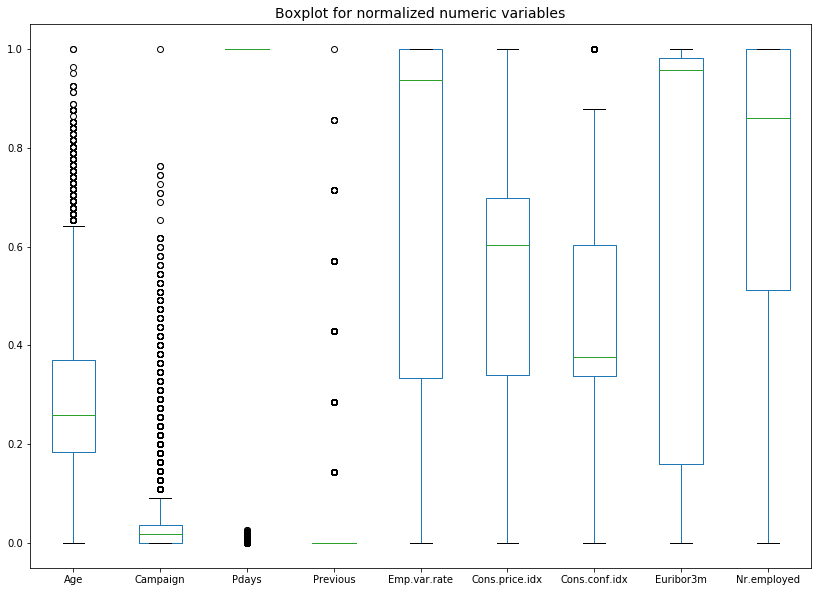

In [5]:
quant = data[['age','campaign','pdays','previous','emp.var.rate','cons.price.idx','cons.conf.idx','euribor3m','nr.employed']]
fig = plt.figure(figsize=(14, 10))
x = quant.values
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
quant = pd.DataFrame(x_scaled)
quant.boxplot()
plt.grid(False)
plt.xticks([1, 2, 3, 4, 5, 6, 7, 8,9],['Age','Campaign','Pdays','Previous','Emp.var.rate','Cons.price.idx','Cons.conf.idx','Euribor3m','Nr.employed'])
plt.title('Boxplot for normalized numeric variables', fontsize=14)
plt.show()

In [6]:
data['job'].unique()

array(['housemaid', 'services', 'admin.', 'blue-collar', 'technician',
       'retired', 'management', 'unemployed', 'self-employed', 'unknown',
       'entrepreneur', 'student'], dtype=object)

### We see that job contains some unknown data so we need to check if response is independent on the unknown values of the job. Therefore the job can be grouped into known and unknown categories. Then they will be tested using the contigency table

In [7]:
job_known = data[data['job']!='unknown']
job_known_yes = job_known[job_known['y']=='yes'].y.value_counts().sum()
job_known_no = job_known[job_known['y']=='no'].y.value_counts().sum()

job_unknown = data[data['job']=='unknown']
job_unknown_yes = job_unknown[job_unknown['y']=='yes'].y.value_counts().sum()
job_unknown_no = job_unknown[job_unknown['y']=='no'].y.value_counts().sum()

obs = np.array([[job_known_no, job_known_yes], [job_unknown_no, job_unknown_yes]])
print("Observed values:\n",obs)
stats.chi2_contingency(obs)
# output are the t-test statistic, p value and the expected values as 2 x 2 array

Observed values:
 [[36255  4603]
 [  293    37]]


(0.0032104107038062905,
 0.954815650813677,
 1,
 array([[36255.17587647,  4602.82412353],
        [  292.82412353,    37.17587647]]))

### The Chi-square test for 2 x 2 contignency table indicates that p value = 0.9548 meaning H0 hypothesis(independence) can be accepted, i.e., the unknown status (missing data for job) does not impact the outcome of response. The missing of job data is randomly missed and therefore we may delete those missing data. There are 330 missing data for job need to be removed.

In [8]:
data = data[data['job']!='unknown']
print(data.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40858 entries, 0 to 41187
Data columns (total 21 columns):
age               40858 non-null int64
job               40858 non-null object
marital           40858 non-null object
education         40858 non-null object
default           40858 non-null object
housing           40858 non-null object
loan              40858 non-null object
contact           40858 non-null object
month             40858 non-null object
day_of_week       40858 non-null object
duration          40858 non-null int64
campaign          40858 non-null int64
pdays             40858 non-null int64
previous          40858 non-null int64
poutcome          40858 non-null object
emp.var.rate      40858 non-null float64
cons.price.idx    40858 non-null float64
cons.conf.idx     40858 non-null float64
euribor3m         40858 non-null float64
nr.employed       40858 non-null float64
y                 40858 non-null object
dtypes: float64(5), int64(5), object(11)
memory usa

In [9]:
data['marital'].unique()

array(['married', 'single', 'divorced', 'unknown'], dtype=object)

In [10]:
marital_known = data[data['marital']!='unknown']
marital_known_yes = marital_known[marital_known['y']=='yes'].y.value_counts().sum()
marital_known_no = marital_known[marital_known['y']=='no'].y.value_counts().sum()

marital_unknown = data[data['marital']=='unknown']
marital_unknown_yes = marital_unknown[marital_unknown['y']=='yes'].y.value_counts().sum()
marital_unknown_no = marital_unknown[marital_unknown['y']=='no'].y.value_counts().sum()

obs = np.array([[marital_known_no, marital_known_yes], [marital_unknown_no, marital_unknown_yes]])
print("Observed values:\n",obs)
stats.chi2_contingency(obs)
# output are the t-test statistic, p value and the expected values as 2 x 2 array



Observed values:
 [[36193  4594]
 [   62     9]]


(0.03546075783643671,
 0.8506334349774844,
 1,
 array([[3.61919988e+04, 4.59500125e+03],
        [6.30012482e+01, 7.99875177e+00]]))

### The Chi-square test for 2 x 2 contignency table indicates that p value = 0.8506 meaning H0 hypothesis(independence) can be accepted, i.e., the unknown status (missing data for marital) does not impact the outcome of response. The missing of marital data is randomly missed and therefore we may delete those missing data. There are 71 missing data for marital status need to be removed.

In [11]:
data = data[data['marital']!='unknown']
print(data.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40787 entries, 0 to 41187
Data columns (total 21 columns):
age               40787 non-null int64
job               40787 non-null object
marital           40787 non-null object
education         40787 non-null object
default           40787 non-null object
housing           40787 non-null object
loan              40787 non-null object
contact           40787 non-null object
month             40787 non-null object
day_of_week       40787 non-null object
duration          40787 non-null int64
campaign          40787 non-null int64
pdays             40787 non-null int64
previous          40787 non-null int64
poutcome          40787 non-null object
emp.var.rate      40787 non-null float64
cons.price.idx    40787 non-null float64
cons.conf.idx     40787 non-null float64
euribor3m         40787 non-null float64
nr.employed       40787 non-null float64
y                 40787 non-null object
dtypes: float64(5), int64(5), object(11)
memory usa

In [12]:
data['education'].unique()

array(['basic.4y', 'high.school', 'basic.6y', 'basic.9y',
       'professional.course', 'unknown', 'university.degree',
       'illiterate'], dtype=object)

In [13]:
education_known = data[data['education']!='unknown']
education_known_yes = education_known[education_known['y']=='yes'].y.value_counts().sum()
education_known_no = education_known[education_known['y']=='no'].y.value_counts().sum()

education_unknown = data[data['education']=='unknown']
education_unknown_yes = education_unknown[education_unknown['y']=='yes'].y.value_counts().sum()
education_unknown_no = education_unknown[education_unknown['y']=='no'].y.value_counts().sum()

obs = np.array([[education_known_no, education_known_yes], [education_unknown_no, education_unknown_yes]])
print("Observed values:\n",obs)
stats.chi2_contingency(obs)
# output are the t-test statistic, p value and the expected values as 2 x 2 array

Observed values:
 [[34831  4360]
 [ 1362   234]]


(18.839319987021295,
 1.4220510422823373e-05,
 1,
 array([[34776.76374825,  4414.23625175],
        [ 1416.23625175,   179.76374825]]))

### The Chi-square test for 2 x 2 contignency table indicates that p value = 1.422 e -5 meaning H0 hypothesis(independence) cannot be accepted, i.e., the unknown status (missing data for education) impacts the outcome of response. Therefore we are to keep the missing data for education and use them as new category.

In [14]:
data['default'].unique()

array(['no', 'unknown', 'yes'], dtype=object)

In [15]:
default_known = data[data['default']!='unknown']
default_known_yes = default_known[default_known['y']=='yes'].y.value_counts().sum()
default_known_no = default_known[default_known['y']=='no'].y.value_counts().sum()

default_unknown = data[data['default']=='unknown']
default_unknown_yes = default_unknown[default_unknown['y']=='yes'].y.value_counts().sum()
default_unknown_no = default_unknown[default_unknown['y']=='no'].y.value_counts().sum()

obs = np.array([[default_known_no, default_known_yes], [default_unknown_no, default_unknown_yes]])
print("Observed values:\n",obs)
stats.chi2_contingency(obs)
# output are the t-test statistic, p value and the expected values as 2 x 2 array

Observed values:
 [[28193  4158]
 [ 8000   436]]


(394.5576157356691,
 8.427395364909715e-88,
 1,
 array([[28707.1798122,  3643.8201878],
        [ 7485.8201878,   950.1798122]]))

### The Chi-square test for 2 x 2 contignency table indicates that p value = 8.427 e -88 meaning H0 hypothesis(independence) cannot be accepted, i.e., the unknown status (missing data for default) impacts the outcome of response. Therefore we are to keep the missing data for default and use them as new category.

In [16]:
data['housing'].unique()

array(['no', 'yes', 'unknown'], dtype=object)

In [17]:
housing_known = data[data['housing']!='unknown']
housing_known_yes = housing_known[housing_known['y']=='yes'].y.value_counts().sum()
housing_known_no = housing_known[housing_known['y']=='no'].y.value_counts().sum()

housing_unknown = data[data['housing']=='unknown']
housing_unknown_yes = housing_unknown[housing_unknown['y']=='yes'].y.value_counts().sum()
housing_unknown_no = housing_unknown[housing_unknown['y']=='no'].y.value_counts().sum()

obs = np.array([[housing_known_no, housing_known_yes], [housing_unknown_no, housing_unknown_yes]])
print("Observed values:\n",obs)
stats.chi2_contingency(obs)
# output are the t-test statistic, p value and the expected values as 2 x 2 array

Observed values:
 [[35316  4487]
 [  877   107]]


(0.11566252063728887,
 0.7337872991241348,
 1,
 array([[35319.83178464,  4483.16821536],
        [  873.16821536,   110.83178464]]))

### The Chi-square test for 2 x 2 contignency table indicates that p value = 0.7337 meaning H0 hypothesis (independence) can be accepted, i.e., the unknown status (missing data for housing) doe not impact the outcome of response. Since there are 2.4% data are unknown housing, it is not wise to remove them.

In [18]:
data['loan'].unique()

array(['no', 'yes', 'unknown'], dtype=object)

In [19]:
loan_known = data[data['loan']!='unknown']
loan_known_yes = loan_known[loan_known['y']=='yes'].y.value_counts().sum()
loan_known_no = loan_known[loan_known['y']=='no'].y.value_counts().sum()

loan_unknown = data[data['loan']=='unknown']
loan_unknown_yes = loan_unknown[loan_unknown['y']=='yes'].y.value_counts().sum()
loan_unknown_no = loan_unknown[loan_unknown['y']=='no'].y.value_counts().sum()

obs = np.array([[loan_known_no, loan_known_yes], [loan_unknown_no, loan_unknown_yes]])
print("Observed values:\n",obs)
stats.chi2_contingency(obs)
# output are the t-test statistic, p value and the expected values as 2 x 2 array

Observed values:
 [[35316  4487]
 [  877   107]]


(0.11566252063728887,
 0.7337872991241348,
 1,
 array([[35319.83178464,  4483.16821536],
        [  873.16821536,   110.83178464]]))

In [20]:
y_yes = data[data['y']=='yes']['y'].value_counts().sum()
y_no = data[data['y']=='no']['y'].value_counts().sum()
yes_pct = y_yes /(y_yes+y_no)
print("Percentage of subjects made deposits: %.3f" %yes_pct)

Percentage of subjects made deposits: 0.113


### We can see from calculation that the percentage of making deposits is about 11.3% of all subjects.

## Exploratory data analysis (EDA)

### It is reasonable to divide ages into groups such as Young, Middle age and senior to study impact on the deposits

In [21]:
#group age into three categories: 17-35 young, 36-55 middle age, and 56+ senior
bins = [17, 35, 55, 100]
labels = ['young', 'middle-age', 'senior']
data['agerange'] = pd.cut(data.age, bins, labels = labels,include_lowest = True)

In [22]:
def depositvar(var, data,title,xlabel,figsave):
    index = data[var].unique().tolist()
    df = pd.DataFrame(index = index, columns=['Yes_total', 'No_total', 'Yes_pct', 'No_pct'])
    for i in index:
        section = (data[var]==i)
        total = data[section][var].value_counts().sum()
        Yes_total = data[section & (data['y']=='yes')][var].value_counts().sum()
        Yes_pct = Yes_total / total 
        No_total = data[section & (data['y']=='no')][var].value_counts().sum()
        No_pct = No_total /total
        df1 = pd.DataFrame({'Yes_total' : Yes_total, 'No_total': No_total, 'Yes_pct':Yes_pct, 'No_pct':No_pct}, index=[i])
        df.update(df1)
    ax = df[['Yes_total','No_total']].plot(kind='bar', use_index=True,figsize=(14, 10),color=['blue','orange'],alpha=0.8)
    plt.xticks(rotation = 0)
    plt.title(title)
    plt.xlabel(xlabel)
    ax2 = ax.twinx()
    ax2.plot(df[['Yes_pct']].values, linestyle='-', marker='o', linewidth=2.0, color='blue')
    ax2.plot(df[['No_pct']].values, linestyle='-', marker='o', linewidth=2.0, color='orange')
    plt.savefig(figsave)    
    
    return ;

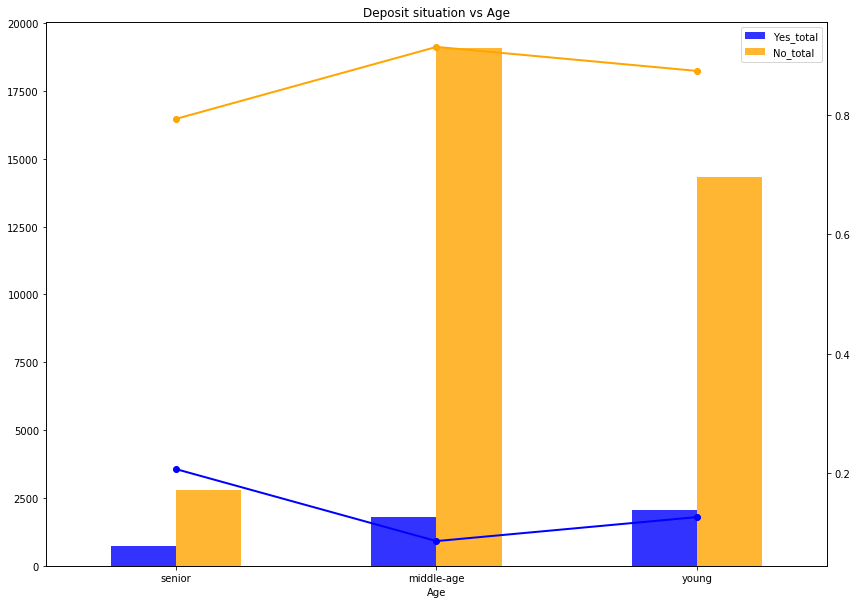

In [23]:
depositvar('agerange', data,'Deposit situation vs Age','Age','Deposit_age')

### It can been seen that more fraction of senior made deposits but young and middle aged take more percentage.

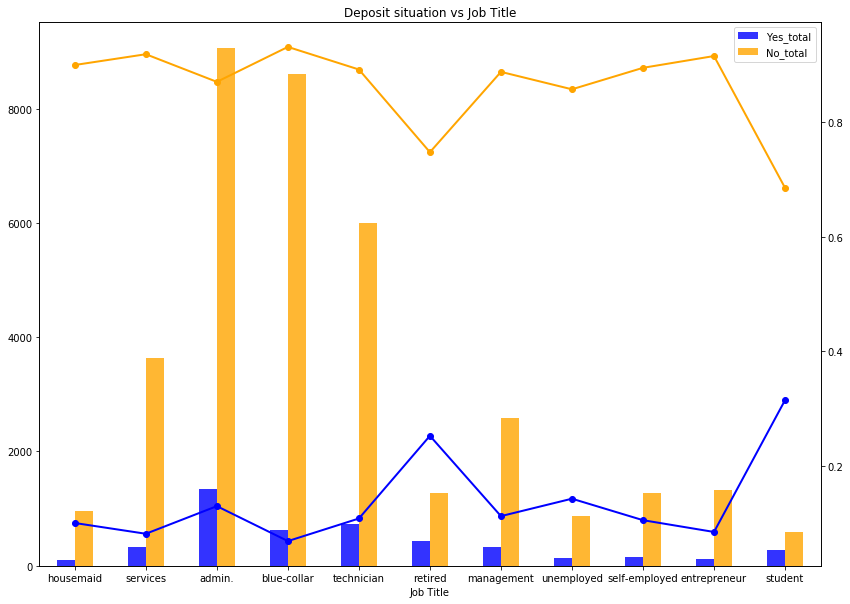

In [24]:
depositvar('job', data,'Deposit situation vs Job Title','Job Title','Deposit_job')

### It seems that the situation of making deposits among all employment status correlate to the employment.

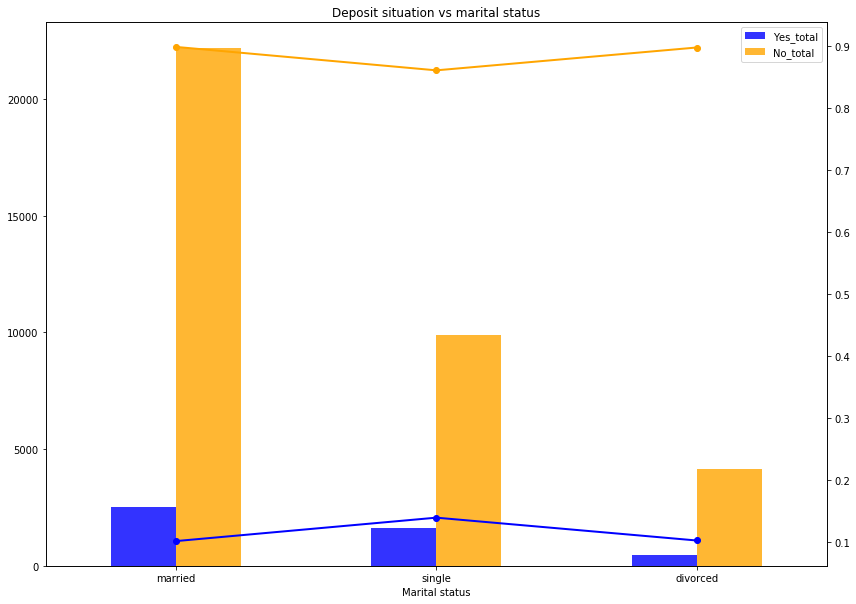

In [25]:
depositvar('marital', data,'Deposit situation vs marital status','Marital status','Deposit_marital')

In [26]:
table = pd.crosstab(data.marital,data.y)           
table.div(table.sum(1).astype(float), axis=0)

y,no,yes
marital,,
divorced,0.897152,0.102848
married,0.898113,0.101887
single,0.860362,0.139638


### It seems that the marital status does not affect the deposit. About 10% all marital status made deposits.

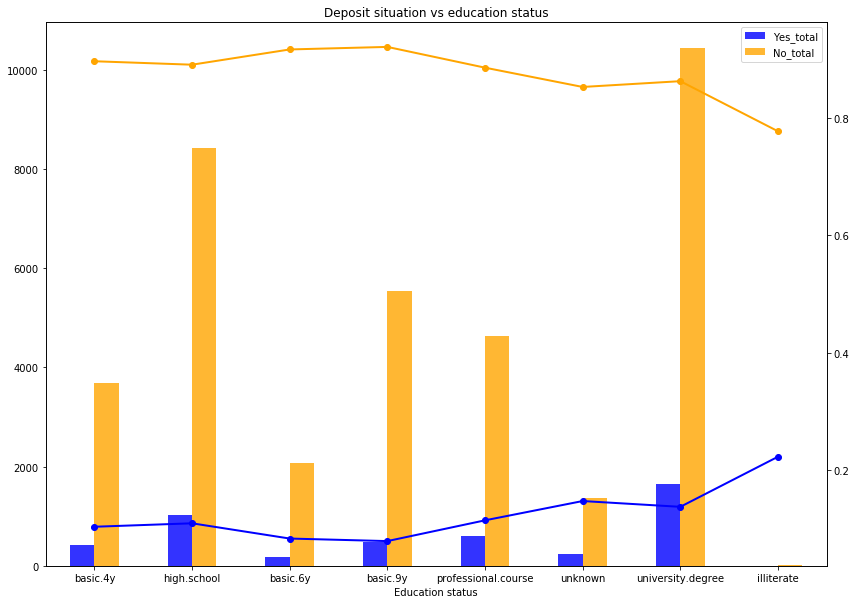

In [27]:
depositvar('education', data,'Deposit situation vs education status','Education status','Deposit_education')

### 14% of university degree holder made deposits and this group makes the majority of all people of interest. It seems that those having more education made more deposits

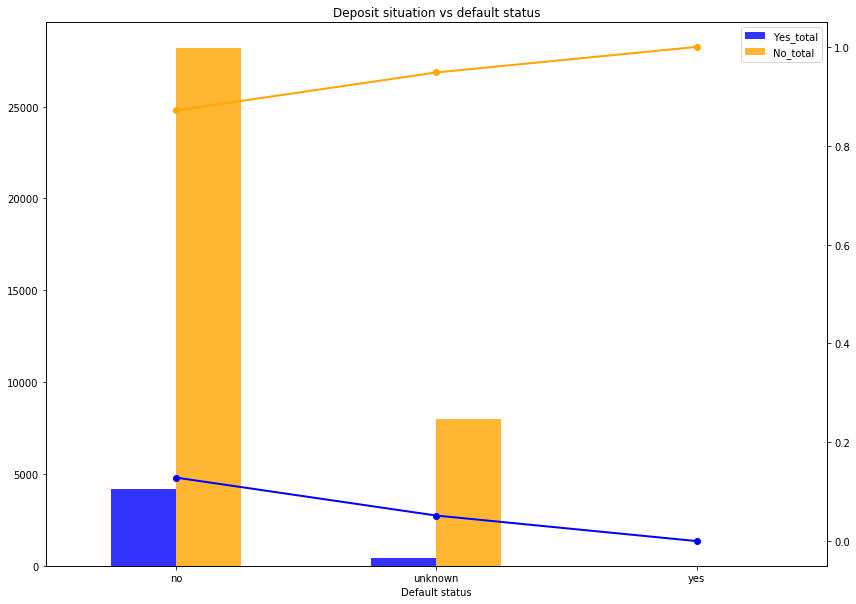

In [28]:
depositvar('default', data,'Deposit situation vs default status','Default status','Deposit_default')

### It seems that the default status doe not impact deposit since most of people do not default and about 13% of them made deposits.

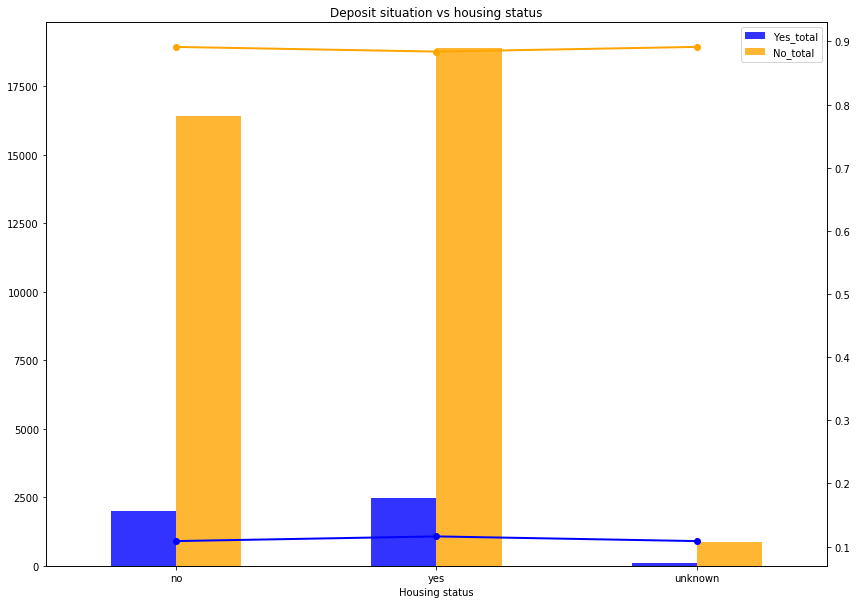

In [29]:
depositvar('housing', data,'Deposit situation vs housing status','Housing status','Deposit_housing')

### It is obvious that the housing status does not impact the deposits.

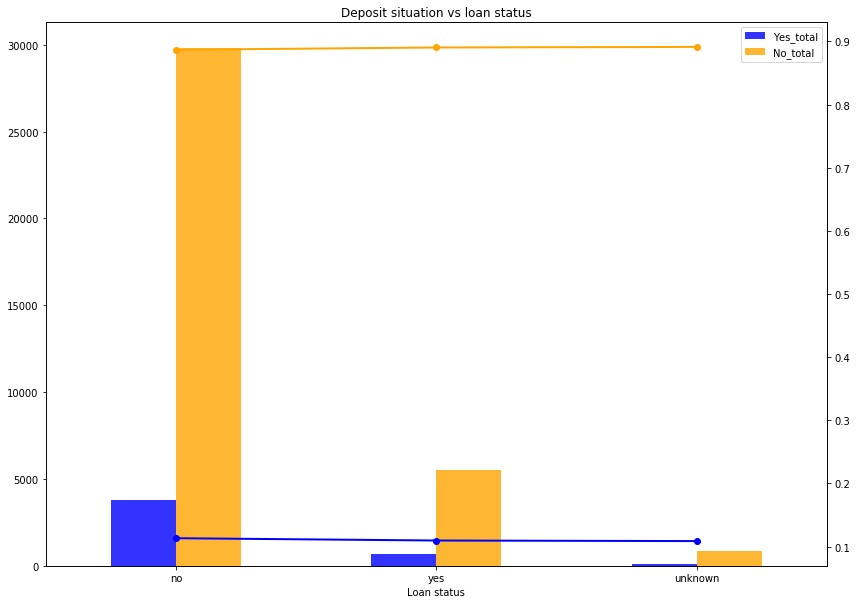

In [30]:
depositvar('loan', data,'Deposit situation vs loan status','Loan status','Deposit_Loan')

### It is obvious that the loan does not affect the deposits.

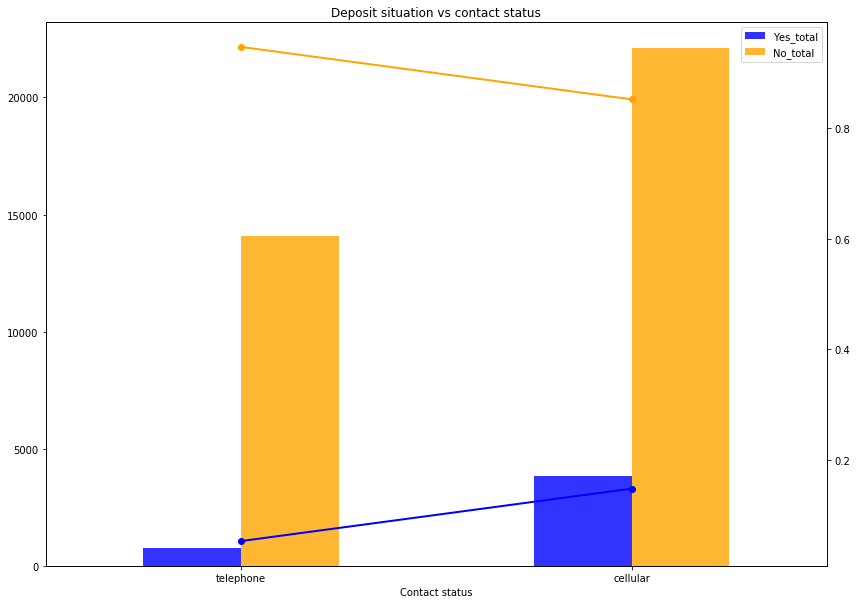

In [31]:
depositvar('contact', data,'Deposit situation vs contact status','Contact status','Deposit_Contact')

### It indicates that more people are using cell phone than regular phones. Meanwhile about 15% cell phone users made deposits

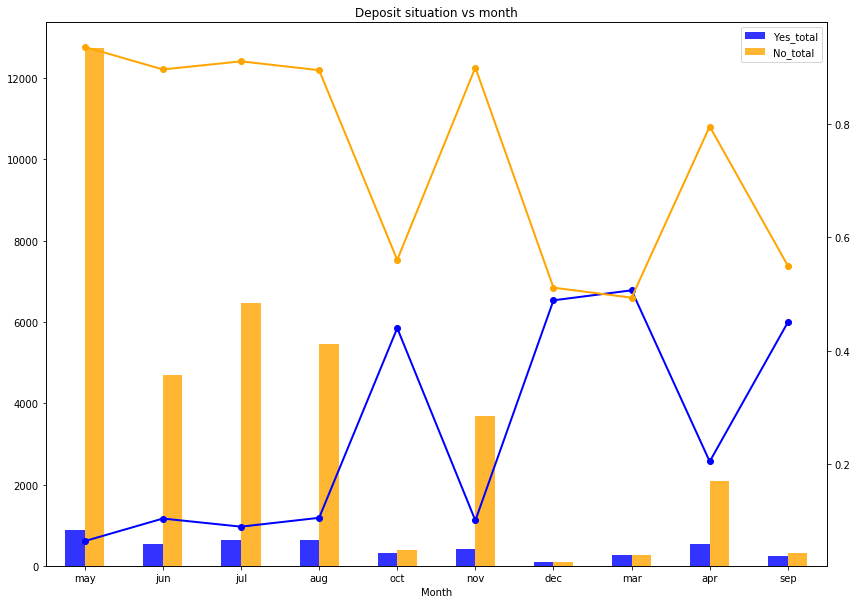

In [32]:
depositvar('month', data,'Deposit situation vs month','Month','Deposit_month')

### It is shown that deposits is dependent on the month of a year.

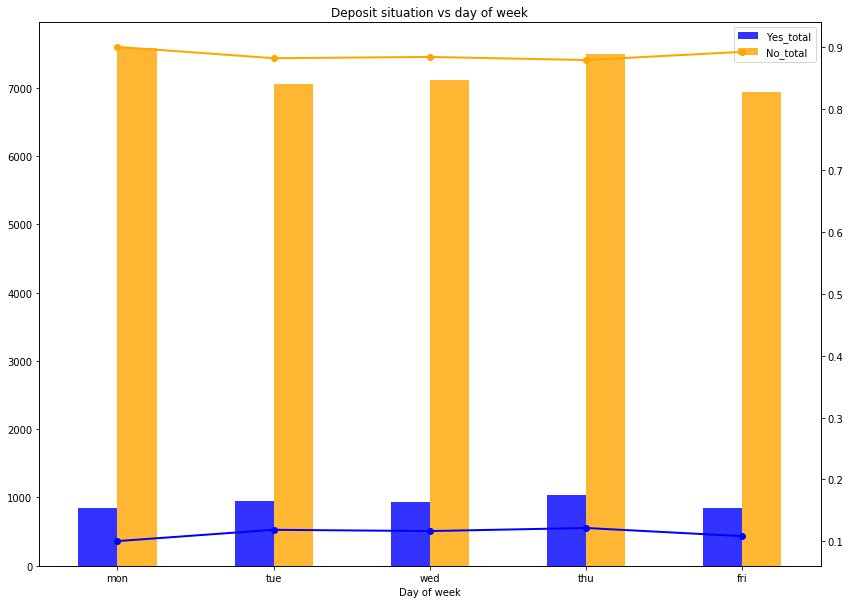

In [33]:
depositvar('day_of_week', data,'Deposit situation vs day of week','Day of week','Deposit_day')

### There is no dependence of day of week on the deposits and all weekdays about 11% people made deposits

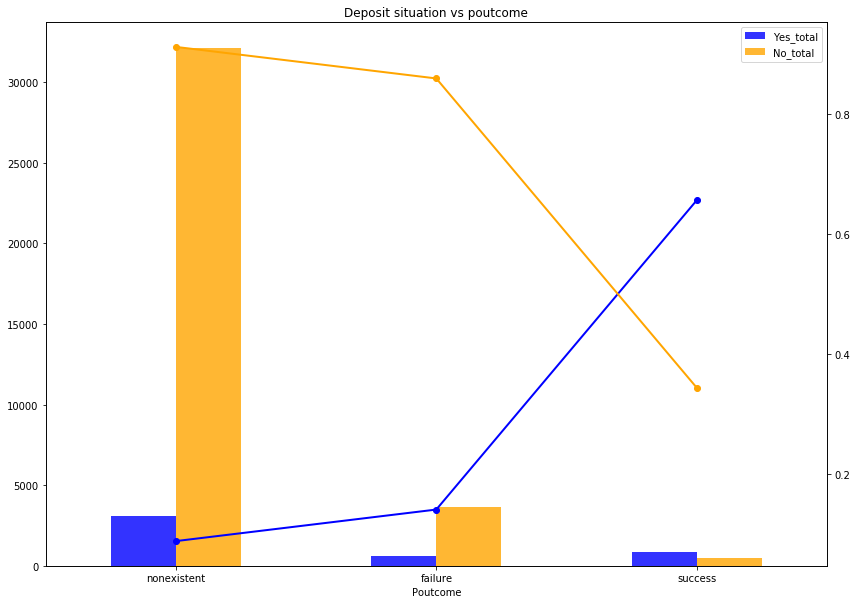

In [34]:
depositvar('poutcome', data,'Deposit situation vs poutcome','Poutcome','Deposit_Poutcome')

### The relationship between poutcome and deposits: success of marketing campaign leads to more deposits.

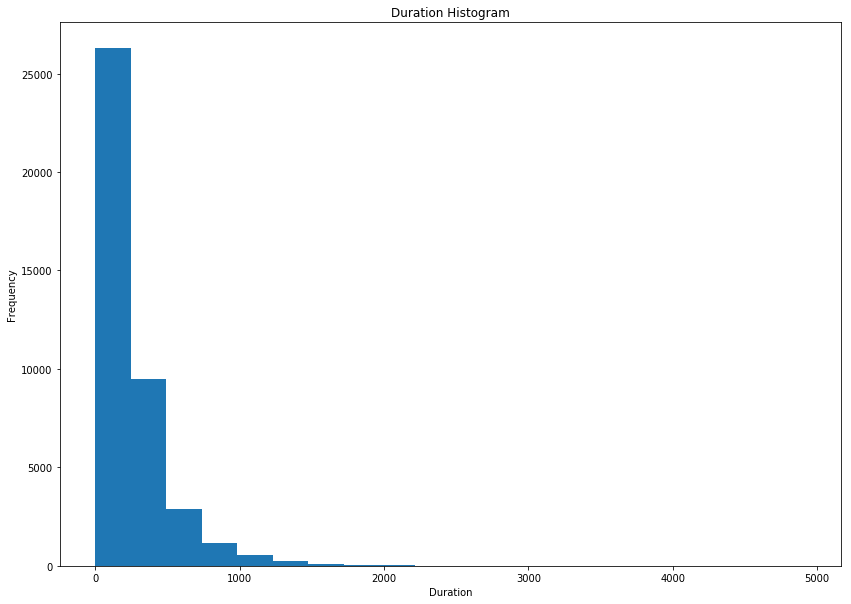

In [35]:
fig = plt.figure(figsize=(14, 10))
plt.hist(data['duration'],bins=20)
plt.title("Duration Histogram")
plt.xlabel("Duration")
plt.ylabel("Frequency")
plt.savefig('Duration histogram')

In [36]:
#group duration into three categories: 0-102 short, 103-319 medium, and 320+ long
bins = [0, 102, 319, 4918]
labels = ['short', 'medium', 'long']
data['durationrange'] = pd.cut(data.duration, bins, labels = labels,include_lowest = True)

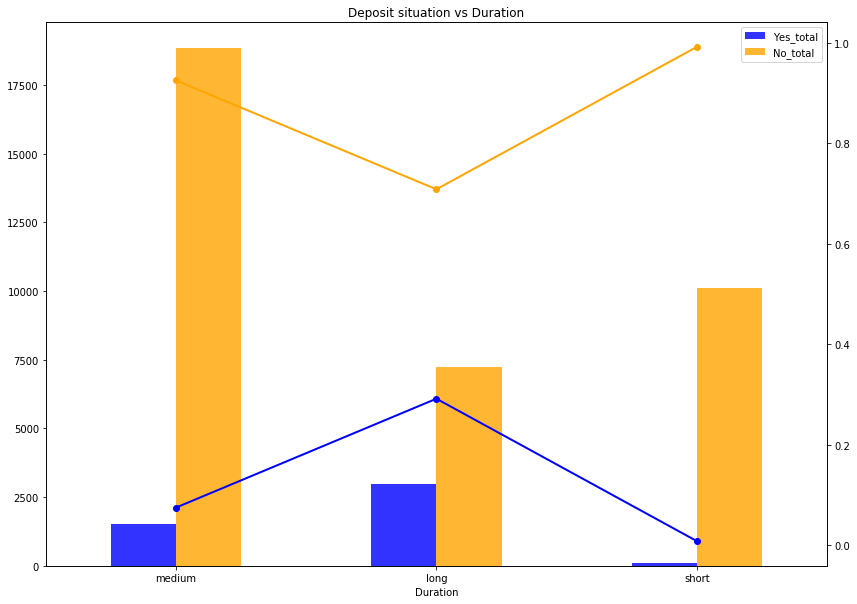

In [37]:
depositvar('durationrange', data,'Deposit situation vs Duration','Duration','Deposit_Duration')

### The relationship between duration and deposits: longer the duration, more fractions people made deposits.

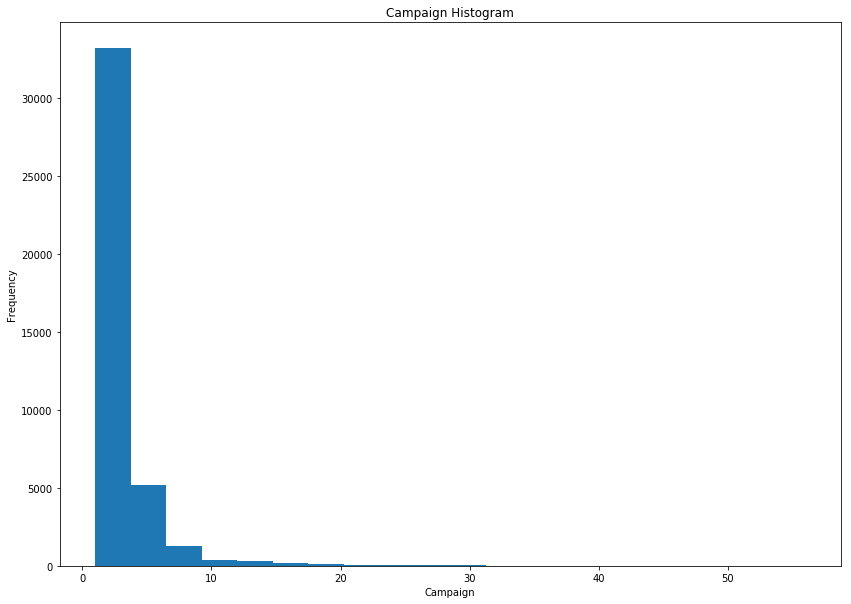

In [38]:
fig = plt.figure(figsize=(14, 10))
plt.hist(data['campaign'],bins=20)
plt.title("Campaign Histogram")
plt.xlabel("Campaign")
plt.ylabel("Frequency")
plt.savefig('Campaign histogram')

In [39]:
#group campaign into three categories: 0-1 small, 2-5 medium, and 6+ large
bins = [0, 1, 5, 56]
labels = ['small', 'medium', 'large']
data['campaignrange'] = pd.cut(data.campaign, bins, labels = labels,include_lowest = True)

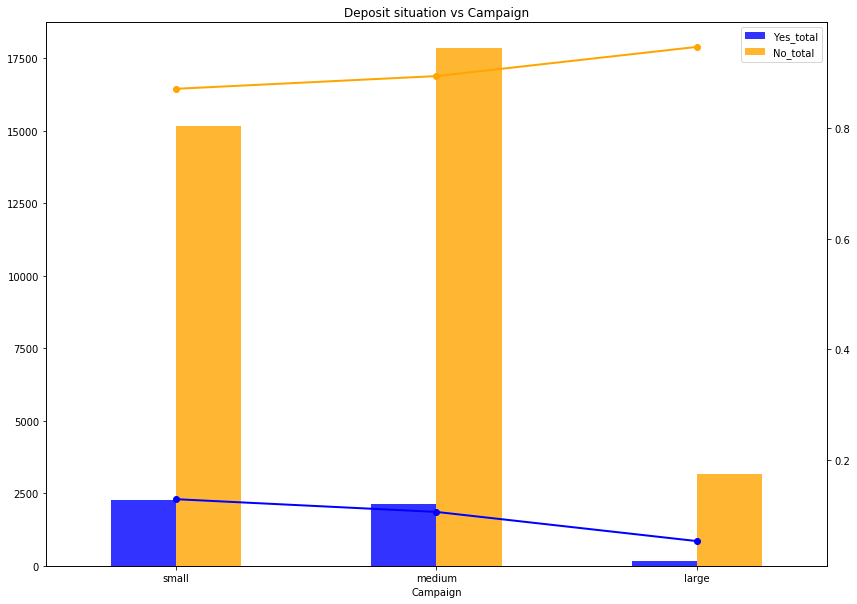

In [40]:
depositvar('campaignrange', data,'Deposit situation vs Campaign','Campaign','Deposit_Campaign')

### It shows that the bigger of the size of the campaign, less people made deposits.

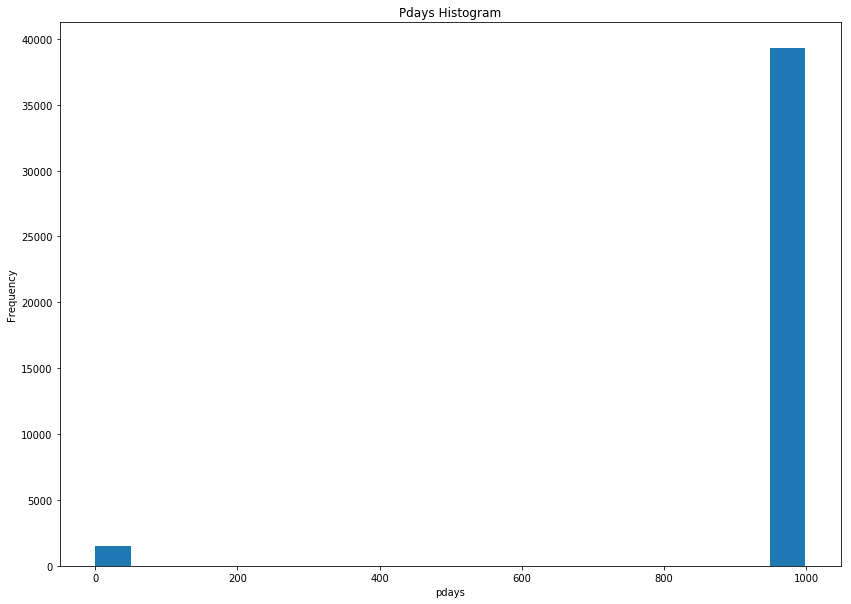

In [41]:
# pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
fig = plt.figure(figsize=(14, 10))
plt.hist(data['pdays'],bins=20)
plt.title("Pdays Histogram")
plt.xlabel("pdays")
plt.ylabel("Frequency")
plt.savefig('Pdays histogram')

In [42]:
#group pdays into three categories: 0-6 short, 7-21 medium, 22-27 long, and 28-999 never
bins = [0, 6, 21, 27, 999]
labels = ['short', 'medium', 'long','never']
data['pdaysrange'] = pd.cut(data.pdays, bins, labels = labels,include_lowest = True)

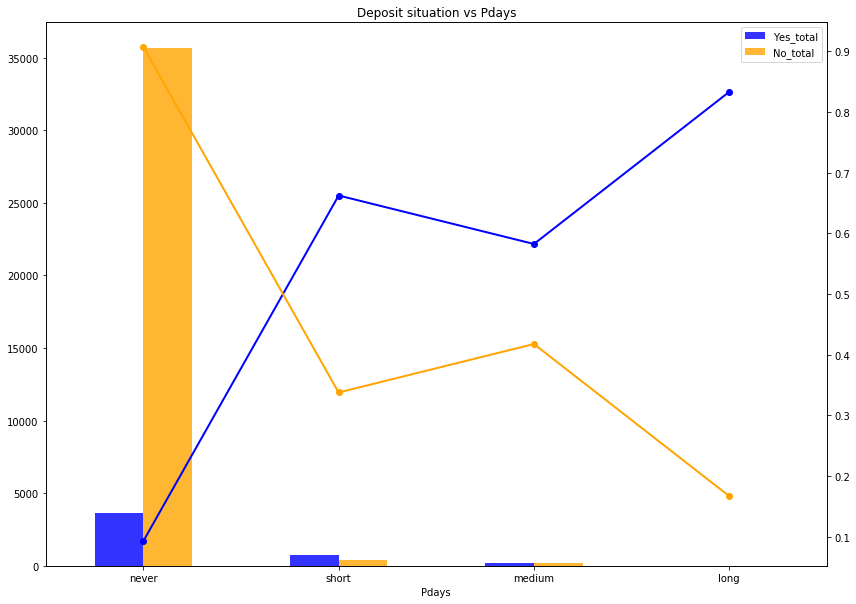

In [43]:
depositvar('pdaysrange', data,'Deposit situation vs Pdays','Pdays','Deposit_Pdays')

### It can be seen that shorter the pdays, more people made deposits.

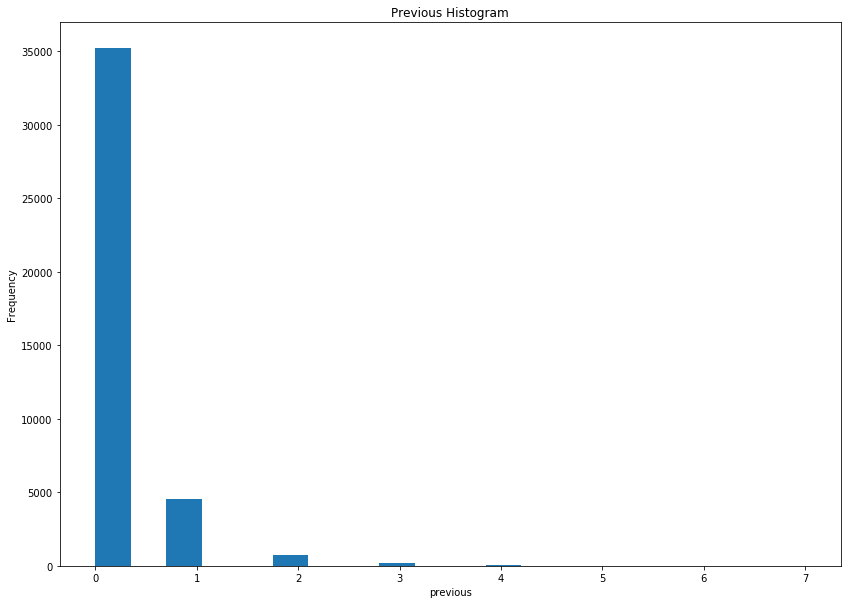

In [44]:
# previous: number of contacts performed before this campaign and for this client (numeric)
fig = plt.figure(figsize=(14, 10))
plt.hist(data['previous'],bins=20)
plt.title("Previous Histogram")
plt.xlabel("previous")
plt.ylabel("Frequency")
plt.savefig('Previous histogram')

In [45]:
#group previous into three categories: 0-1 less, 2-5 medium, 6-7 more
bins = [0, 1, 5, 7]
labels = ['less', 'medium', 'more']
data['previousrange'] = pd.cut(data.previous, bins, labels = labels,include_lowest = True)

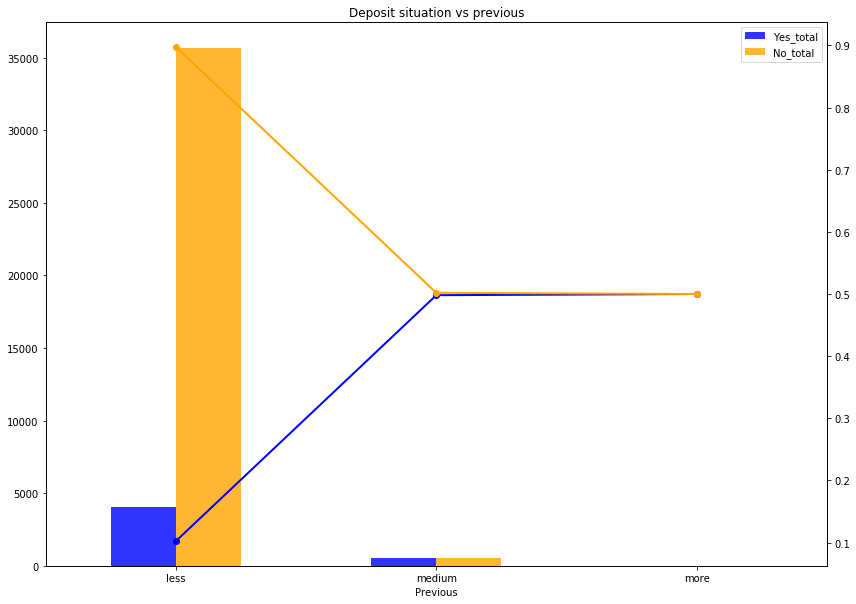

In [46]:
depositvar('previousrange', data,'Deposit situation vs previous','Previous','Deposit_previous')

### It shows that the more previous contact, more people made deposits.

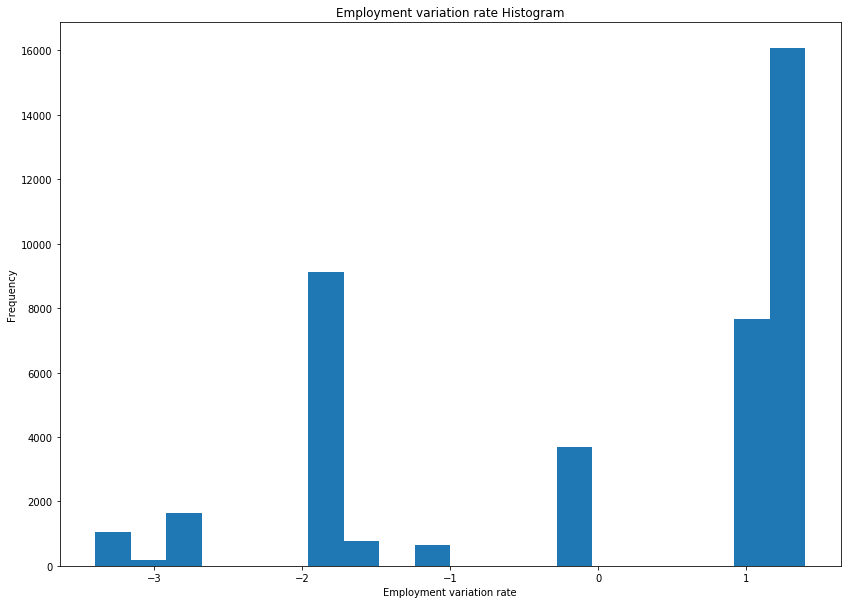

In [47]:
# emp.var.rate: employment variation rate - quarterly indicator (numeric)
fig = plt.figure(figsize=(14, 10))
plt.hist(data['emp.var.rate'],bins=20)
plt.title("Employment variation rate Histogram")
plt.xlabel("Employment variation rate")
plt.ylabel("Frequency")
plt.savefig('Employment variation rate histogram')

In [48]:
#group emp.var.rate into three categories: -3.40--2 small, -2-0 medium, 0-1.4 large
bins = [-3.40, -2, 0, 1.4]
labels = ['small', 'medium', 'large']
data['emp.var.raterange'] = pd.cut(data['emp.var.rate'], bins, labels = labels,include_lowest = True)

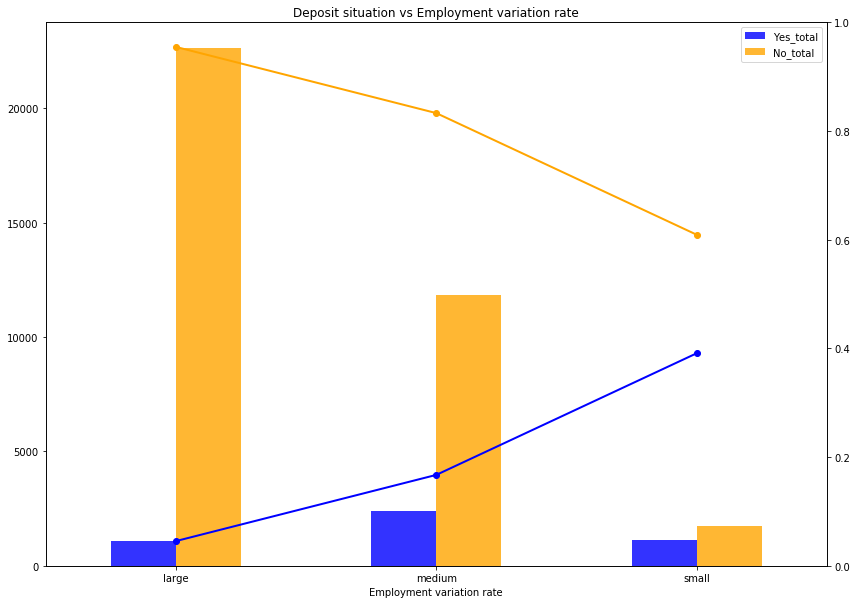

In [49]:
depositvar('emp.var.raterange', data,'Deposit situation vs Employment variation rate','Employment variation rate','Deposit_Employment variation rate')

### It is clear that increase of employment variation rate leads to less people making deposits.

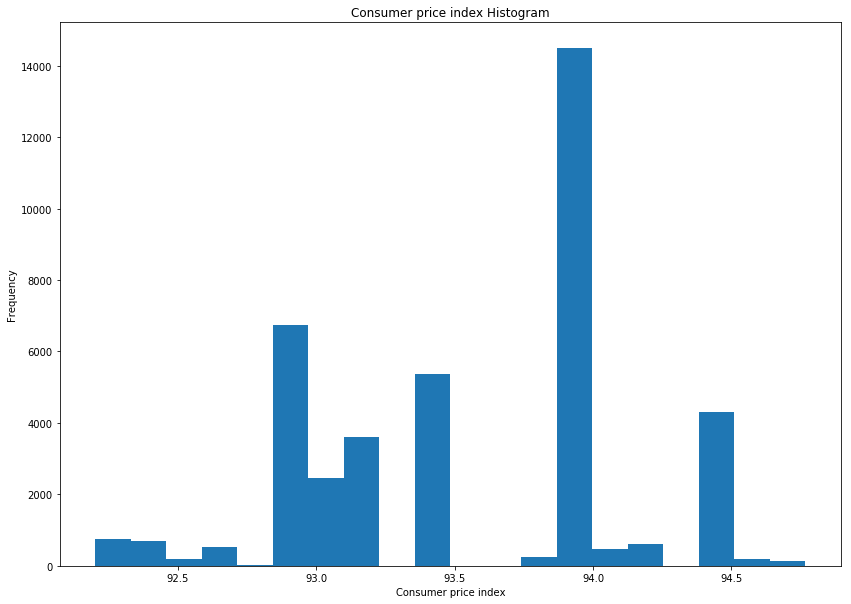

In [50]:
# cons.price.idx: consumer price index - monthly indicator (numeric) 
fig = plt.figure(figsize=(14, 10))
plt.hist(data['cons.price.idx'],bins=20)
plt.title("Consumer price index Histogram")
plt.xlabel("Consumer price index")
plt.ylabel("Frequency")
plt.savefig('Consumer price index histogram')

In [51]:
#group cons.price.idx into three categories: 92.2-93 small, 93-94 medium, 94-94.5 large
bins = [92.2, 93, 94, 94.5]
labels = ['small', 'medium', 'large']
data['cons.price.idxrange'] = pd.cut(data['cons.price.idx'], bins, labels = labels,include_lowest = True)

C:\Users\VT\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in longlong_scalars
  
C:\Users\VT\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in longlong_scalars
  # Remove the CWD from sys.path while we load stuff.


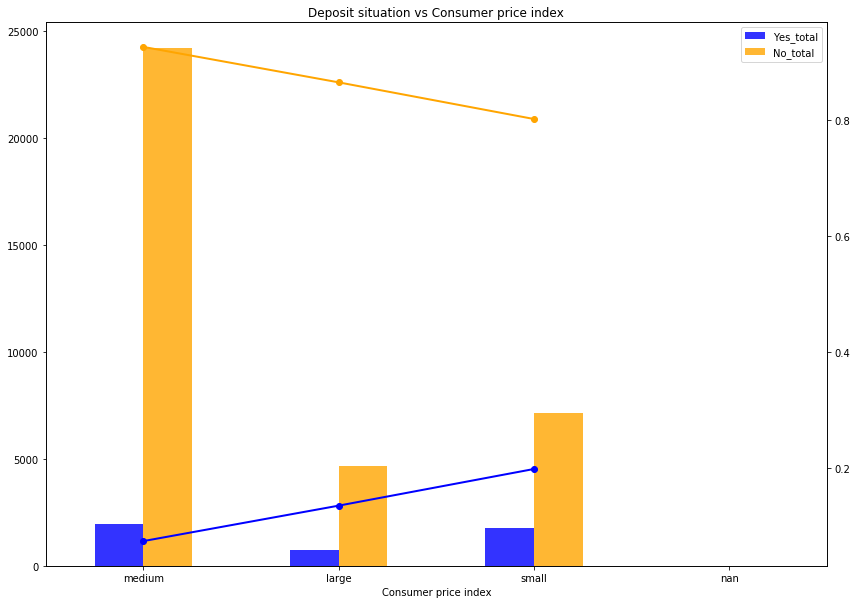

In [52]:
depositvar('cons.price.idxrange', data,'Deposit situation vs Consumer price index','Consumer price index','Deposit_Consumer price index')

### The relationship between deposits and consumer price index is not clear.

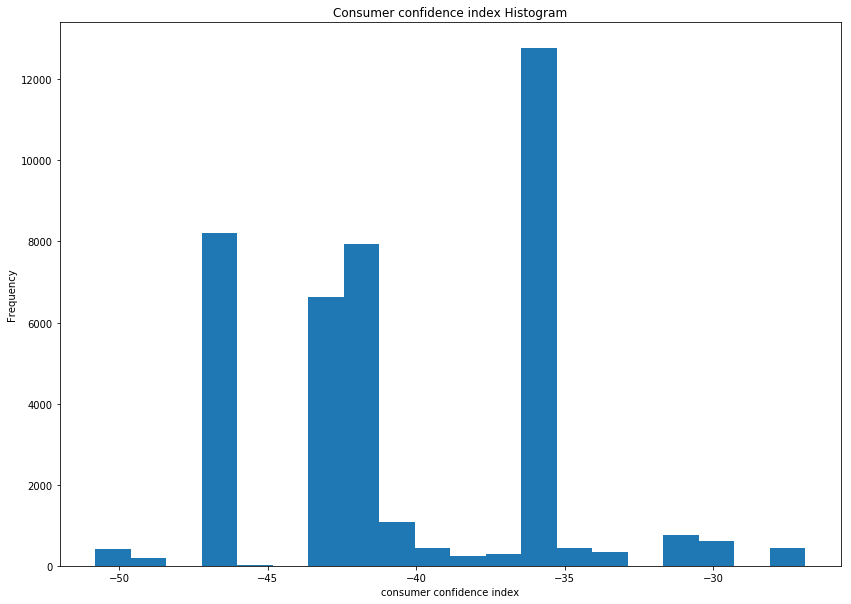

In [53]:
#  cons.conf.idx: consumer confidence index - monthly indicator (numeric)
fig = plt.figure(figsize=(14, 10))
plt.hist(data['cons.conf.idx'],bins=20)
plt.title("Consumer confidence index Histogram")
plt.xlabel("consumer confidence index")
plt.ylabel("Frequency")
plt.savefig('consumer confidence index histogram')

In [54]:
#group cons.conf.idx into three categories: -50.8--45 small, -45--35 medium, -35--30 large
bins = [-50.8, -45, -35, -30]
labels = ['small', 'medium', 'large']
data['cons.conf.idxrange'] = pd.cut(data['cons.conf.idx'], bins, labels = labels,include_lowest = True)

C:\Users\VT\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in longlong_scalars
  
C:\Users\VT\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in longlong_scalars
  # Remove the CWD from sys.path while we load stuff.


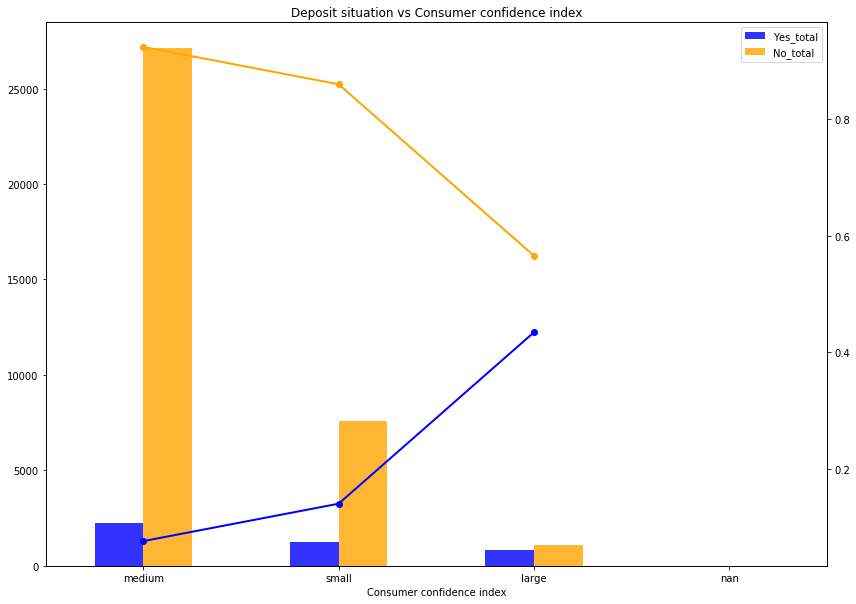

In [55]:
depositvar('cons.conf.idxrange', data,'Deposit situation vs Consumer confidence index','Consumer confidence index','Deposit_Consumer confidence index')

### It seems that the larger the consumer confidence index, more people made deposits.

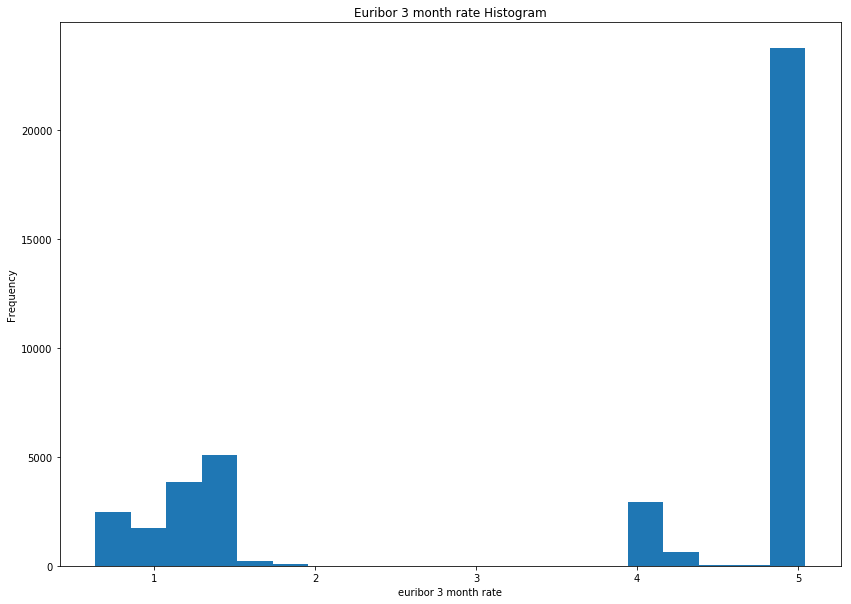

In [56]:
# euribor3m: euribor 3 month rate - daily indicator (numeric)
fig = plt.figure(figsize=(14, 10))
plt.hist(data['euribor3m'],bins=20)
plt.title("Euribor 3 month rate Histogram")
plt.xlabel("euribor 3 month rate")
plt.ylabel("Frequency")
plt.savefig('euribor 3 month rate histogram')

In [57]:
#group euribor3m into three categories: 0.63-2 small, 2-4 medium, 4-5.05 large
bins = [0.63,2,4,5.05]
labels = ['small', 'medium', 'large']
data['euribor3mrange'] = pd.cut(data['euribor3m'], bins, labels = labels,include_lowest = True)

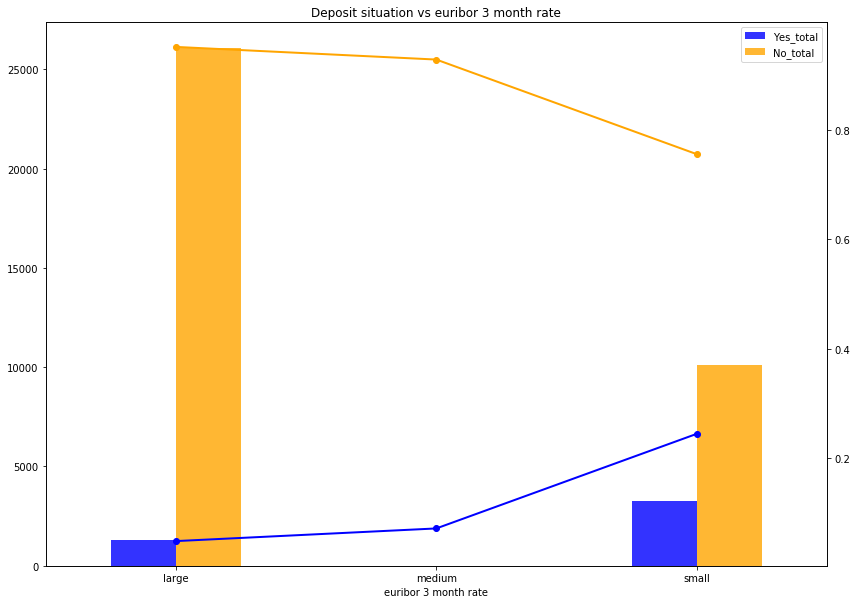

In [58]:
depositvar('euribor3mrange', data,'Deposit situation vs euribor 3 month rate','euribor 3 month rate','Deposit_euribor 3 month rate')

### It is obvious that larger of euribor 3 month rate, less people made deposits.

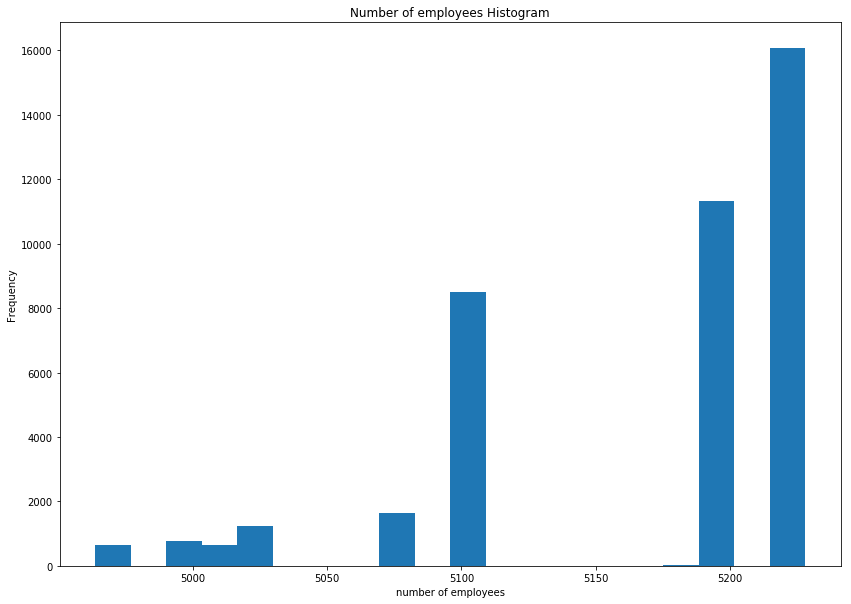

In [59]:
#  nr.employed: number of employees - quarterly indicator (numeric)
fig = plt.figure(figsize=(14, 10))
plt.hist(data['nr.employed'],bins=20)
plt.title("Number of employees Histogram")
plt.xlabel("number of employees")
plt.ylabel("Frequency")
plt.savefig('Number of employees histogram')

In [60]:
# group nr.employed into three categories: 4963-5050 small, 5050-5200 medium, 5200-5228 large
bins = [4960,5050,5200,5229]
labels = ['small', 'medium', 'large']
data['nr.employedrange'] = pd.cut(data['nr.employed'], bins, labels = labels,include_lowest = True)

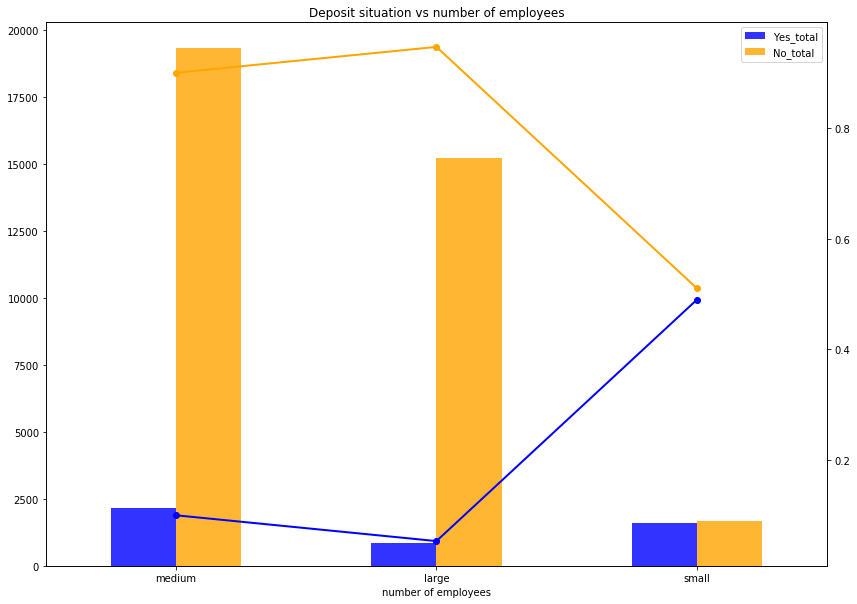

In [61]:
depositvar('nr.employedrange', data,'Deposit situation vs number of employees','number of employees','Deposit_number of employees')

### It is apparrent that larger the number of employed, the less people made deposits.

                     age  duration  campaign     pdays  previous  \
age             1.000000 -0.001630  0.007218 -0.026581  0.012882   
duration       -0.001630  1.000000 -0.072014 -0.046451  0.017085   
campaign        0.007218 -0.072014  1.000000  0.047444 -0.074822   
pdays          -0.026581 -0.046451  0.047444  1.000000 -0.571994   
previous        0.012882  0.017085 -0.074822 -0.571994  1.000000   
emp.var.rate    0.025908 -0.024522  0.141607  0.261747 -0.429685   
cons.price.idx  0.020104  0.006031  0.125678  0.090112 -0.241285   
cons.conf.idx   0.116580 -0.009674 -0.001151 -0.102092 -0.054808   
euribor3m       0.032356 -0.029054  0.125447  0.283755 -0.454588   
nr.employed     0.009502 -0.040427  0.134238  0.355284 -0.495372   

                emp.var.rate  cons.price.idx  cons.conf.idx  euribor3m  \
age                 0.025908        0.020104       0.116580   0.032356   
duration           -0.024522        0.006031      -0.009674  -0.029054   
campaign            0.141607 

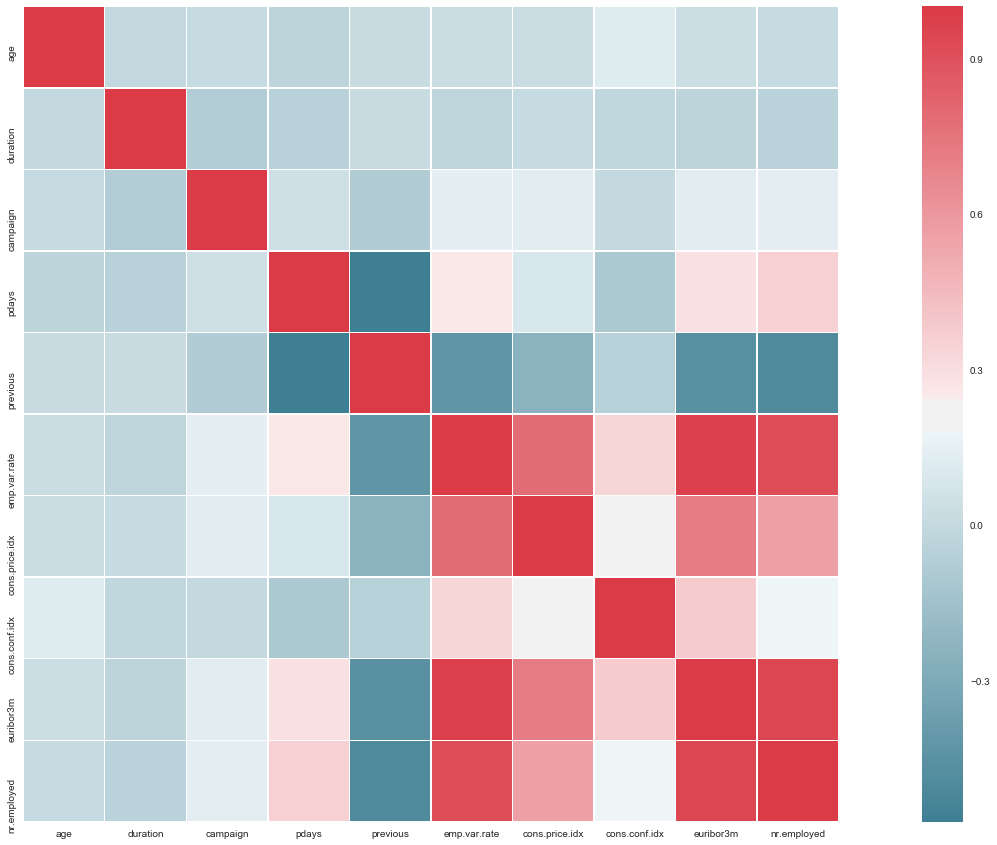

In [62]:
#following are calculations for correlation matrix between all vaiables of dataset data
#print(final_data.columns)
#Corelation Matrix
sns.set(style="white")
df_corr = data[:]

# Compute the correlation matrix
corr = df_corr.dropna().corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)

# Set up the matplotlib figure
fig, ax = plt.subplots(figsize=(30, 15))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, square=True, linewidths=.5, ax=ax)

print(corr)

### There are three variables strongly correlated to one another, i.e., euribor3m, number of employed and employment variation rate. Cor(euribor3m, number of employed) = 0.949215; Cor(euribor3m, employment variation rate) = 0.975380 and Cor(employment variation rate, number of employed) = 0.914747 . Therefore only one varialbe is to stay in final model, employment variation rate.

In [63]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40787 entries, 0 to 41187
Data columns (total 31 columns):
age                    40787 non-null int64
job                    40787 non-null object
marital                40787 non-null object
education              40787 non-null object
default                40787 non-null object
housing                40787 non-null object
loan                   40787 non-null object
contact                40787 non-null object
month                  40787 non-null object
day_of_week            40787 non-null object
duration               40787 non-null int64
campaign               40787 non-null int64
pdays                  40787 non-null int64
previous               40787 non-null int64
poutcome               40787 non-null object
emp.var.rate           40787 non-null float64
cons.price.idx         40787 non-null float64
cons.conf.idx          40787 non-null float64
euribor3m              40787 non-null float64
nr.employed            40787 non-null

###  19 features selected for models:

In [64]:
data_dmy = pd.get_dummies(data, columns =['job','month', 'poutcome'],drop_first=True)
data_dmy.loc[data_dmy.y == 'yes','y'] = 1
data_dmy.loc[data_dmy.y == 'no','y'] = 0
data_vars=data_dmy.columns.values.tolist()
removal_vars = ['marital','default','housing','previous','education','contact','job_self-employed','job_unemployed','job_technician','job_housemaid','job_management','job_student','loan','day_of_week','euribor3m','poutcome_success','cons.price.idx','cons.conf.idx','nr.employed','agerange', 'durationrange', 'campaignrange', 'pdaysrange', 'previousrange', 'euribor3mrange', 'cons.price.idxrange', 'cons.conf.idxrange', 'emp.var.raterange', 'nr.employedrange']
keep=[i for i in data_vars if i not in removal_vars]
final_data = data_dmy[keep]

final_data.columns.values


array(['age', 'duration', 'campaign', 'pdays', 'emp.var.rate', 'y',
       'job_blue-collar', 'job_entrepreneur', 'job_retired',
       'job_services', 'month_aug', 'month_dec', 'month_jul', 'month_jun',
       'month_mar', 'month_may', 'month_nov', 'month_oct', 'month_sep',
       'poutcome_nonexistent'], dtype=object)

In [65]:
final_data_vars = final_data.columns.values.tolist()

y = ['y']
X = [i for i in final_data_vars if i not in y]

 ### We can see from calculation that the percentage of making deposits is about 11.2% of all subjects. The goal of this project is to predict the chance of people making deposit and the dataset makes imbalanced in term of this goal. Therefore it is feasible to either reduce the portion of non-making deposits or increase the portion of making depostis.

In [66]:
data_dmy[X].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40787 entries, 0 to 41187
Data columns (total 19 columns):
age                     40787 non-null int64
duration                40787 non-null int64
campaign                40787 non-null int64
pdays                   40787 non-null int64
emp.var.rate            40787 non-null float64
job_blue-collar         40787 non-null uint8
job_entrepreneur        40787 non-null uint8
job_retired             40787 non-null uint8
job_services            40787 non-null uint8
month_aug               40787 non-null uint8
month_dec               40787 non-null uint8
month_jul               40787 non-null uint8
month_jun               40787 non-null uint8
month_mar               40787 non-null uint8
month_may               40787 non-null uint8
month_nov               40787 non-null uint8
month_oct               40787 non-null uint8
month_sep               40787 non-null uint8
poutcome_nonexistent    40787 non-null uint8
dtypes: float64(1), int64(4), uint

### Oversample the minor group-purhcase

In [67]:
X_train, X_test, y_train, y_test = train_test_split(data_dmy[X],data_dmy['y'], test_size=0.1, random_state=0)
sm = SMOTE(random_state=12) # ovesampliing the minor group- purchase
X_train_res, y_train_res = sm.fit_sample(X_train, y_train)

In [68]:
len(X_test)

4079

## Logistic Regression:
### Tune the logistic model to get optimal C

In [69]:
# Setup the hyperparameter grid
c_space = np.logspace(-3, 4, 15)
param_grid = {'C': c_space, 'penalty': ['l1', 'l2']}

# Instantiate a logistic regression classifier: logreg

logreg = LogisticRegression(fit_intercept = False,random_state=0)

# Instantiate the GridSearchCV object: logreg_cv
logreg_cv = GridSearchCV(logreg, param_grid, cv=10)

# Fit it to the data
logreg_cv.fit(X_train_res, y_train_res)

# Print the tuned parameter and score
print("Tuned Logistic Regression Parameters: {}".format(logreg_cv.best_params_))
print("Best score is {}".format(logreg_cv.best_score_))


Tuned Logistic Regression Parameters: {'C': 100.0, 'penalty': 'l1'}
Best score is 0.8762391431114385


In [70]:
from sklearn.cross_validation import cross_val_score, cross_val_predict
from sklearn import metrics
LogReg = LogisticRegression(fit_intercept = False, C = 100,random_state=0)
LogReg.fit(X_train_res.astype(float), y_train_res.astype(float))
score = LogReg.score(X_train_res.astype(float), y_train_res.astype(float))
print('Accuracy of logistic regression classifier on training set: {:.2f}\n'.format(score))

y_pred = LogReg.predict(X_test)
print('Accuracy of logistic regression classifier on testing set: {:.2f}\n'.format(LogReg.score(X_test, y_test)))

C:\Users\VT\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


Accuracy of logistic regression classifier on training set: 0.88

Accuracy of logistic regression classifier on testing set: 0.86



### Calculate the importance of 19 selected features

In [71]:
columns = data_dmy[X].columns.values.tolist()
print(columns)
df_x = pd.DataFrame(X_train_res, columns =columns) 

['age', 'duration', 'campaign', 'pdays', 'emp.var.rate', 'job_blue-collar', 'job_entrepreneur', 'job_retired', 'job_services', 'month_aug', 'month_dec', 'month_jul', 'month_jun', 'month_mar', 'month_may', 'month_nov', 'month_oct', 'month_sep', 'poutcome_nonexistent']


Importance of features: 
  [[0.010987979738896834, 0.3515849246566209, 0.029232777136852836, 0.10812850681172388, 0.18890229716495513, 0.03208280823519289, 0.009165358417541881, 0.01555541027160528, 0.015043428491452543, 0.00641133823346212, 0.00014779174859191047, 0.0057616237636150215, 0.0066435496908701175, 0.03807494967956647, 0.091239102197035, 0.03678648019362103, 0.01896444018017205, 0.011633527250598215, 0.02365370613762575]]


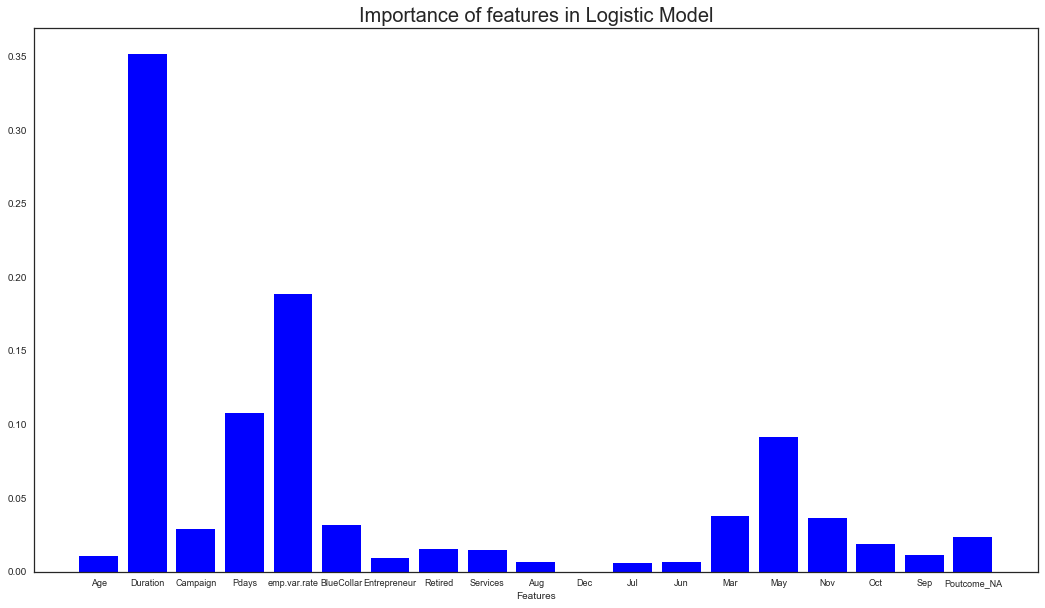

In [72]:
imp = abs(list(np.std(df_x))*LogReg.coef_)
importance = imp.tolist()

s = 0
for row in importance:  #sum up all members in the list
    for elem in row:
        s += elem
rel_imp = imp/s
imp_list = rel_imp.tolist() # normalized imprtance
#columns = X_train.columns.tolist()
columns = ['Age', 'Duration', 'Campaign', 'Pdays', 'emp.var.rate', 'BlueCollar', 'Entrepreneur', 'Retired', 'Services', 'Aug', 'Dec', 'Jul', 'Jun', 'Mar', 'May', 'Nov', 'Oct', 'Sep', 'Poutcome_NA']
y_pos = np.arange(len(columns))

print("Importance of features: \n ",rel_imp.tolist())

fig = plt.figure(figsize=(18, 10))
plt.xticks(y_pos, columns,fontsize=9)
plt.xlabel('Features',fontsize=10)
plt.title('Importance of features in Logistic Model', fontsize =20)
b = [num for elem in rel_imp.tolist() for num in elem] # convert array into a list
plt.bar(y_pos, b, align='center',color='blue')
plt.savefig('Importance feature_log Reg')

In [73]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, y_pred)
print('The confusion matrix is :\n',confusion_matrix)
print(classification_report(y_test, y_pred))

The confusion matrix is :
 [[3113  497]
 [  59  410]]
             precision    recall  f1-score   support

          0       0.98      0.86      0.92      3610
          1       0.45      0.87      0.60       469

avg / total       0.92      0.86      0.88      4079



### The confusion matrix tells us that sensitivity = 3113/(3113 + 59) = 0.981 and specificity = 410/(410 + 497) = 0.451

In [74]:
print('AUC of Logistic Regression is : %.3f'%roc_auc_score(y_test, y_pred))

AUC of Logistic Regression is : 0.868


In [75]:
import statsmodels.api as sm
model = sm.OLS(y_train_res, X_train_res).fit() ## sm.OLS(output, input)
predictions = model.predict(X_test)

# Print out the statistics
print(model.summary(xname=['Age', 'Duration', 'Campaign', 'Pdays', 'emp.var.rate', 'BlueCollar', 'Entrepreneur', 'Retired', 'Services', 'Aug', 'Dec', 'Jul', 'Jun', 'Mar', 'May', 'Nov', 'Oct', 'Sep', 'Poutcome_NA']))

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.754
Model:                            OLS   Adj. R-squared:                  0.754
Method:                 Least Squares   F-statistic:                 1.051e+04
Date:                Sun, 22 Jul 2018   Prob (F-statistic):               0.00
Time:                        00:17:28   Log-Likelihood:                -24195.
No. Observations:               65166   AIC:                         4.843e+04
Df Residuals:                   65147   BIC:                         4.860e+04
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Age              0.0036      0.000     31.350   

### Comparison actual and predicted purhase rate at different age groups

In [76]:
def purchase_var(datax,datay, predy, var, step, title, xlabel,ylabel, savefig ):
    #(events, edges, patches )= plt.hist(data[var],bins=range(min(datax[var]), max(datax[var]) + step, step))
    total = []
    actual = []
    pred = []

    for x in range(min(datax[var]), max(datax[var]) ,step):
        if x == max(datax[var]) - step:
            X_test_idx = (datax[var] >=x)  & (datax[var] <= x+ step)
        else:
            X_test_idx = (datax[var] >=x)  & (datax[var] < x+ step)
        tot = datax[X_test_idx][var].value_counts().sum()    
        total.append(tot)  # total people in age range 1
    
        actual.append((datay[X_test_idx & (datay == 1)].value_counts().sum())/tot) #actual purchase in age range 1
    
        pred.append((predy[X_test_idx & (datay == 1) & (predy == 1)].sum())/tot) # predicted purchase in age range 1
   

    #print(total)
    #print(actual)
    #print(pred)
    
    fig, ax1 = plt.subplots(figsize=(14, 10))
    ax1.set_title(title, fontsize = 20)
    ax1.set_xlabel(xlabel)
    ax1.set_ylabel(ylabel, color='blue')
    ax1.hist(datax[var],normed=1,bins=range(min(datax[var]), max(datax[var]) + step, step), color ='gray',alpha=0.5)

    ax1.tick_params(axis='y', labelcolor='blue')

    xpoint=[]
    for x in range(min(datax[var]), max(datax[var]), step):
        xpoint.append(x+step/2)

    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

    ax2.set_ylabel('Percentage of purchase', color='black')  # we already handled the x-label with ax1
    p2 = ax2.plot(xpoint, actual, '-rs',color='red',markersize=8,label = 'Actual purchase rate' )
    ax2.set_ylim(0,1)

    ax3 = ax1.twinx()
    p3 = ax3.plot(xpoint, pred,'--ko', color='black',label = 'Predicted purchase rate')
    ax3.set_ylim(0,1)

    p = p2 + p3
    labs = [l.get_label() for l in p]

    ax1.legend(p, labs, loc=0)
    plt.savefig(savefig)
    plt.show()

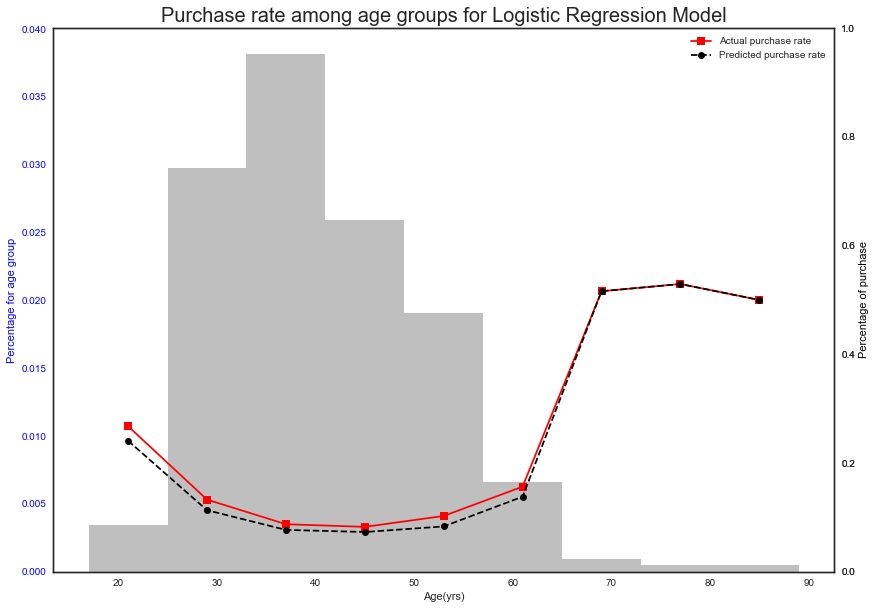

In [77]:
purchase_var(X_test,y_test, y_pred, 'age', 8, 'Purchase rate among age groups for Logistic Regression Model', 'Age(yrs)','Percentage for age group', 'Logistic Reg_pred_actual vs age' )

### Comparison actual and predicted purhase rate at different duration groups

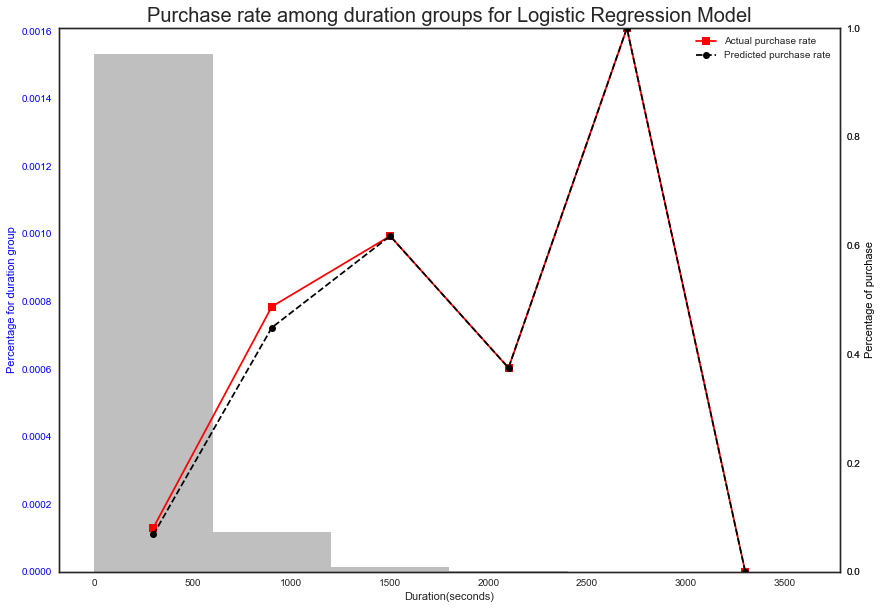

In [78]:
purchase_var(X_test,y_test, y_pred, 'duration', 600, 'Purchase rate among duration groups for Logistic Regression Model', 'Duration(seconds)','Percentage for duration group', 'Logistic Reg_pred_actual vs duration' )

## Random Forest

In [79]:
# Create a random forest Classifier. By convention, clf means 'Classifier'
clf = RandomForestClassifier(n_jobs=100, random_state=0)

# Train the Classifier to take the training features and learn how they relate
# to the training y (the species)
clf.fit(X_train_res,y_train_res)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=100,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

In [80]:
predictions = clf.predict(X_test)
 
# Train and Test Accuracy
print("Train Accuracy :: %.3f " %accuracy_score(y_train_res, clf.predict(X_train_res)))
print("Test Accuracy  :: %.3f" %accuracy_score(y_test, predictions))

Train Accuracy :: 0.996 
Test Accuracy  :: 0.904


In [81]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, predictions)
print('The confusion matrix is :\n',confusion_matrix)
print(classification_report(y_test, predictions))

The confusion matrix is :
 [[3462  148]
 [ 242  227]]
             precision    recall  f1-score   support

          0       0.93      0.96      0.95      3610
          1       0.61      0.48      0.54       469

avg / total       0.90      0.90      0.90      4079



### The confusion matrix tells us that sensitivity = 3462/(3462 + 242) = 0.936 and specificity = 227/(227 + 148) = 0.618

In [82]:
print('AUC of Randoom Forest is : %.3f'%roc_auc_score(y_test, predictions))

AUC of Randoom Forest is : 0.722


In [83]:
importance = clf.feature_importances_
importance

array([0.06094179, 0.33366997, 0.03657193, 0.03872937, 0.18862386,
       0.02089111, 0.00385024, 0.00544575, 0.01295078, 0.03158781,
       0.00141536, 0.04262492, 0.02353772, 0.0214101 , 0.07778689,
       0.04091433, 0.01551981, 0.00711041, 0.03641784])

Importance of features: 
  [0.06094179201130308, 0.33366996940655735, 0.036571929944369516, 0.03872936933389257, 0.18862386250809116, 0.02089110528396994, 0.0038502444312995916, 0.005445753382145999, 0.012950777332123622, 0.03158780548004804, 0.0014153623146897732, 0.04262492453124448, 0.023537723181414016, 0.021410101842190915, 0.07778688527263986, 0.040914327431252166, 0.015519809690694147, 0.007110413414502604, 0.03641784320757115]


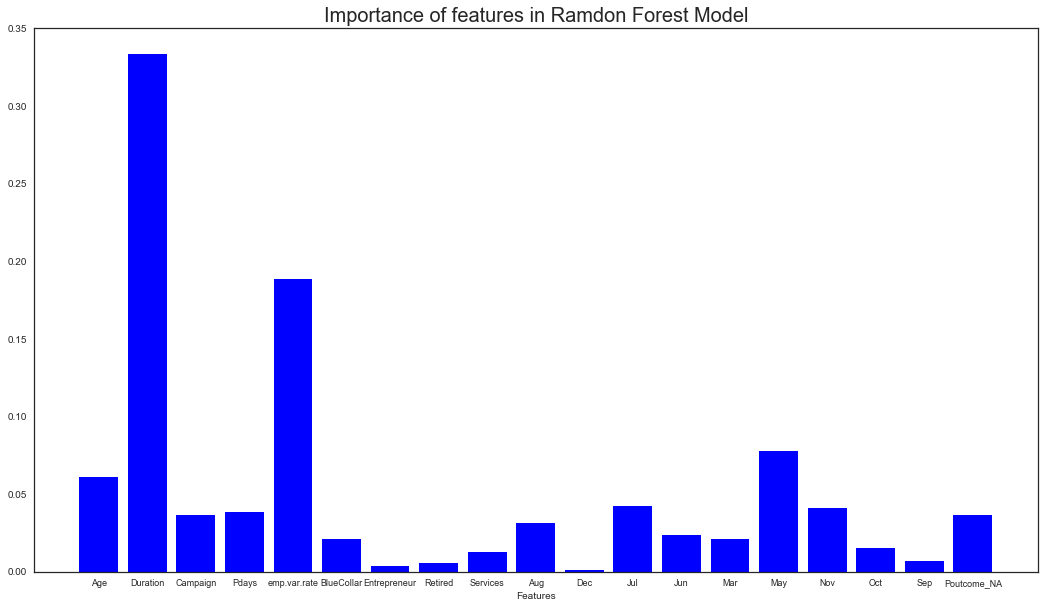

In [84]:
columns = ['Age', 'Duration', 'Campaign', 'Pdays', 'emp.var.rate', 'BlueCollar', 'Entrepreneur', 'Retired', 'Services', 'Aug', 'Dec', 'Jul', 'Jun', 'Mar', 'May', 'Nov', 'Oct', 'Sep', 'Poutcome_NA']
y_pos = np.arange(len(columns))

print("Importance of features: \n ",importance.tolist())

fig = plt.figure(figsize=(18, 10))
plt.xticks(y_pos, columns,fontsize=9)
plt.xlabel('Features',fontsize=10)
plt.title('Importance of features in Ramdon Forest Model', fontsize =20)

plt.bar(y_pos, importance.tolist(), align='center',color='blue')
plt.savefig('Importance feature_Random Forest')

### Comparison actual and predicted purhase rate at different age groups

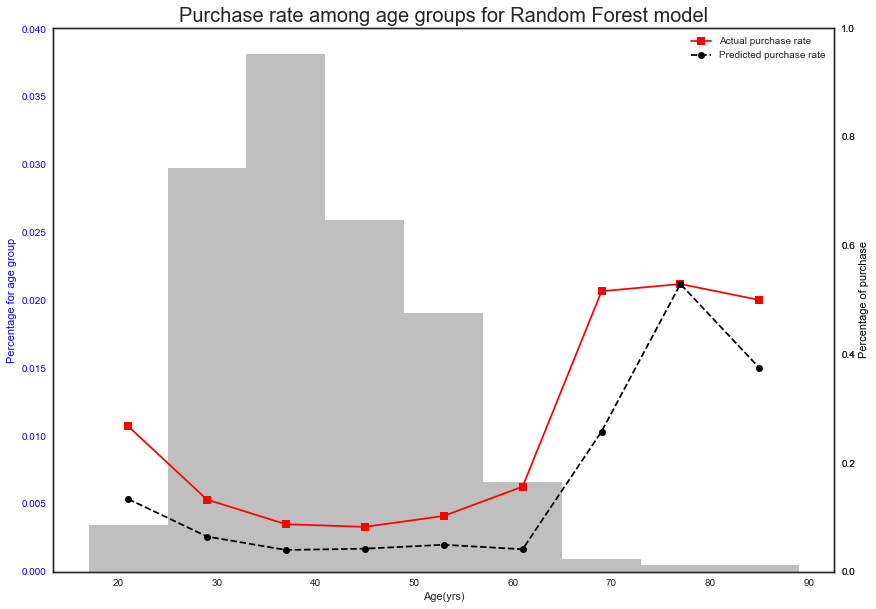

In [85]:
purchase_var(X_test,y_test, predictions, 'age', 8, 'Purchase rate among age groups for Random Forest model', 'Age(yrs)','Percentage for age group', 'Random Forest_pred_actual vs age' )

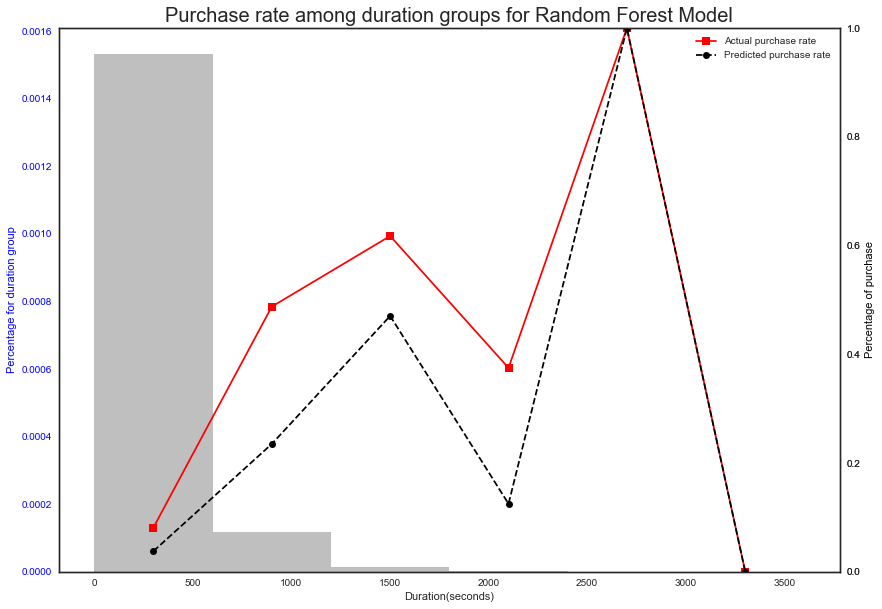

In [86]:
purchase_var(X_test,y_test, predictions, 'duration', 600, 'Purchase rate among duration groups for Random Forest Model', 'Duration(seconds)','Percentage for duration group', 'Random Forest_pred_actual vs duration')

## Decision Tree

In [87]:
clf = DecisionTreeClassifier(criterion = "gini", random_state = 100, max_depth=3, min_samples_leaf=5)
clf.fit(X_train_res, y_train_res)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=5, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=100,
            splitter='best')

In [88]:
predictions = clf.predict(X_test)
 
# Train and Test Accuracy
print("Train Accuracy :: %.3f " %accuracy_score(y_train_res, clf.predict(X_train_res)))
print("Test Accuracy  :: %.3f" %accuracy_score(y_test, predictions))

Train Accuracy :: 0.860 
Test Accuracy  :: 0.813


In [89]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, predictions)
print('The confusion matrix is :\n',confusion_matrix)
print(classification_report(y_test, predictions))

The confusion matrix is :
 [[2952  658]
 [ 105  364]]
             precision    recall  f1-score   support

          0       0.97      0.82      0.89      3610
          1       0.36      0.78      0.49       469

avg / total       0.90      0.81      0.84      4079



In [90]:
print('AUC of Decision Tree is : %.3f'%roc_auc_score(y_test, predictions))

AUC of Decision Tree is : 0.797


In [91]:
importance = clf.feature_importances_
importance

array([0.        , 0.47499809, 0.        , 0.        , 0.41976114,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.10524076,
       0.        , 0.        , 0.        , 0.        ])

Importance of features: 
  [0.0, 0.4749980928808014, 0.0, 0.0, 0.4197611445616723, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.10524076255752636, 0.0, 0.0, 0.0, 0.0]


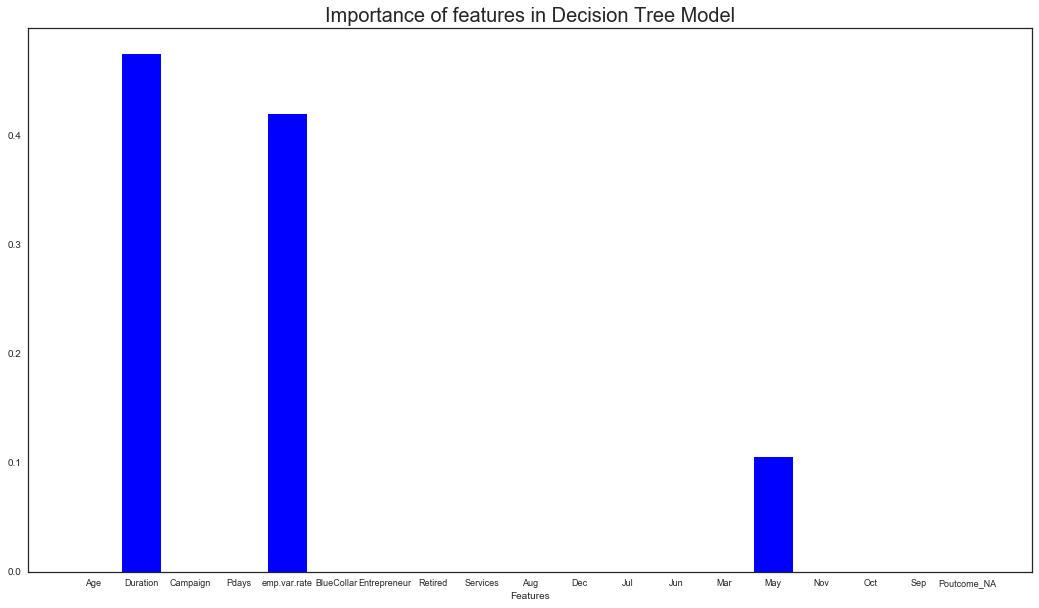

In [92]:
columns = ['Age', 'Duration', 'Campaign', 'Pdays', 'emp.var.rate', 'BlueCollar', 'Entrepreneur', 'Retired', 'Services', 'Aug', 'Dec', 'Jul', 'Jun', 'Mar', 'May', 'Nov', 'Oct', 'Sep', 'Poutcome_NA']
y_pos = np.arange(len(columns))

print("Importance of features: \n ",importance.tolist())

fig = plt.figure(figsize=(18, 10))
plt.xticks(y_pos, columns,fontsize=9)
plt.xlabel('Features',fontsize=10)
plt.title('Importance of features in Decision Tree Model', fontsize =20)

plt.bar(y_pos, importance.tolist(), align='center',color='blue')
plt.savefig('Importance feature_Decision Tree')

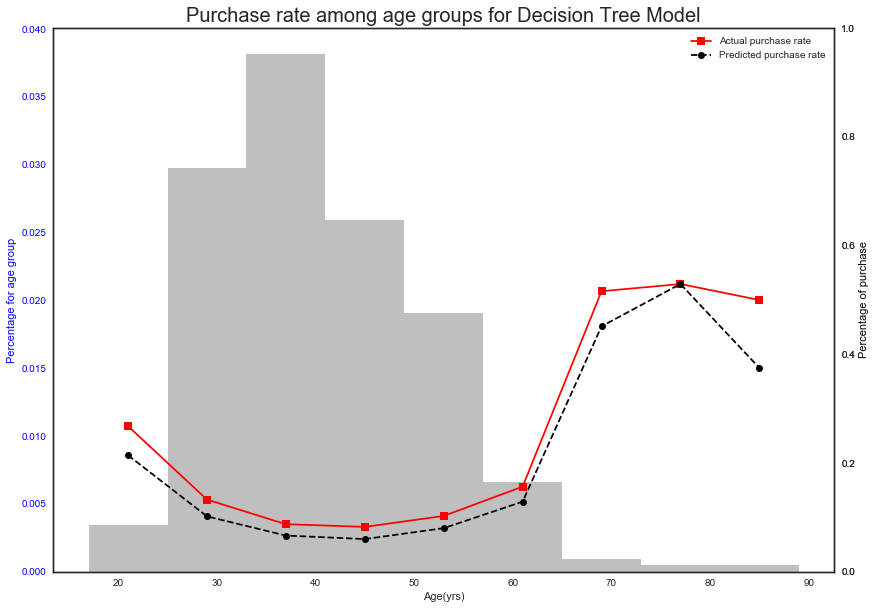

In [93]:
purchase_var(X_test,y_test, predictions, 'age', 8, 'Purchase rate among age groups for Decision Tree Model', 'Age(yrs)','Percentage for age group', 'Decision Tree_pred_actual vs age')

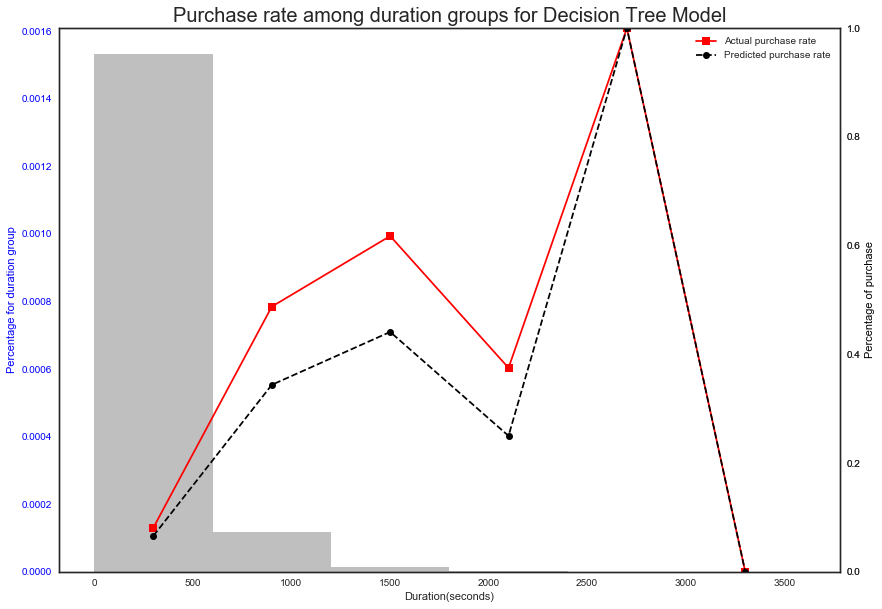

In [94]:
purchase_var(X_test,y_test, predictions, 'duration', 600, 'Purchase rate among duration groups for Decision Tree Model', 'Duration(seconds)','Percentage for duration group', 'Decision Tree_pred_actual vs duration')